# **Data-Science Fundamentals Final Project: predicting flights using ML algorithms**

## Stage No. 1: collecting the data:
- for this stage we will use a web scraper-collector that will collect flights data from two websites: Kiwi and Kayak.
- this collector is built with async-runtime functions, random user-actions generator, session saver, cookies saver, dynamic viewport and even DHCP-ip-refresher function (since were not using proxy), all of these methods are used for collecting without getting cought by these websities bot-identifier machenisms...
- this collector will run every combination of ttt (time to travel) from 1-30, los (lenght of stay) from 1-5 within a 3 different snapshot days for every combination of rome,london and paris routes

In [1]:
%pip install -e scraping
# %playwright install

Obtaining file:///Users/omrishlezinger/Documents/data%20science%20basics/project/DS-Scarping/scraping
  Preparing metadata (setup.py) ... done
  Attempting uninstall: scraping
    Found existing installation: scraping 0.1
    Uninstalling scraping-0.1:
      Successfully uninstalled scraping-0.1
  DEPRECATION: Legacy editable install of scraping==0.1 from file:///Users/omrishlezinger/Documents/data%20science%20basics/project/DS-Scarping/scraping (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for scraping
Note: you may need to restart the kernel to use updated packages.


In [2]:
# from scraping.flights_scraping import get_data


# get_data()


After we have collected the data: were doing the usual imports:

In [3]:
# Basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
import re
import time
import random
import datetime
import warnings
from tqdm import tqdm

##################### Preprocessing imports 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.impute import KNNImputer

##################### Models
# from xgboost import XGBClassifier, XGBRegressor
# from catboost import CatBoostClassifier, CatBoostRegressor
# from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

#### Model selection 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

##################### optuna library import
# !pip install shap
# import optuna
# import shap
import matplotlib.cm as cm
from collections import defaultdict
random_state = 42
n_splits = 5

## Stage 2: Exploring the data

In [4]:
data = pd.read_csv('Flights.csv')

In [5]:
# Table for first look
def summary(train):
    sum = pd.DataFrame(train.dtypes, columns=['dtypes'])
    sum['missing#'] = train.isna().sum()
    sum['missing%'] = (train.isna().sum())/len(train)
    sum['uniques'] = train.nunique().values
    sum['count'] = train.count().values
    return sum

display(summary(data).style.background_gradient(cmap='Blues'))
data.head(1)

,dtypes,missing#,missing%,uniques,count
departure_hour,object,33498,0.067904,415,459813
departure_airport,object,38721,0.078492,13,454590
flight_length,object,33498,0.067904,170,459813
landing_hour,object,37733,0.076489,431,455578
landing_airport,object,38000,0.077031,13,455311
to_dest_company,object,42175,0.085494,35,451136
return_departure_hour,object,33498,0.067904,413,459813
return_departure_airport,object,38693,0.078435,211,454618
return_flight_length,object,33498,0.067904,167,459813
return_landing_hour,object,38693,0.078435,442,454618


,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time
0,6:00a,CIA,2h 45m,7:45a,STN,Ryanair,6:10p,STN,2h 25m,9:35p,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m


In [6]:
data.head()

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time
0,6:00a,CIA,2h 45m,7:45a,STN,Ryanair,6:10p,STN,2h 25m,9:35p,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
1,6:35a,FCO,2h 45m,8:20a,LGW,Wizz Air,9:10a,STN,2h 30m,12:40p,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
2,6:35a,FCO,2h 45m,8:20a,LGW,Wizz Air,6:10p,STN,2h 25m,9:35p,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
3,6:00a,CIA,2h 45m,7:45a,STN,Ryanair,6:10p,STN,2h 25m,9:35p,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m


Remove duplicates and nulls

In [7]:
data = data.drop_duplicates()
data = data.dropna()

we will add a function that will convert the time strings to int (in minutes)

In [8]:

import re
def time_to_minutes(time_str: str)-> int:
    if pd.isna(time_str):
        return 0

    # Extract hours and minutes using regex
    hours = 0
    minutes = 0
    
    h_match = re.search(r'(\d+)h', time_str)
    m_match = re.search(r'(\d+)m', time_str)

    if h_match:
        hours = int(h_match.group(1))
    if m_match:
        minutes = int(m_match.group(1))

    return hours * 60 + minutes

In [9]:
data['flight_length'] = data['flight_length'].apply(time_to_minutes)
data['return_flight_length'] = data['return_flight_length'].apply(time_to_minutes)
data['layover_time'] = data['layover_time'].apply(time_to_minutes)
data['return_layover_time'] = data['return_layover_time'].apply(time_to_minutes)

lets convert the hours to int format

In [10]:
from datetime import datetime
def hour_to_numeric(hour_str):
    hour_str = hour_str.strip()  

    
    match = re.search(r"\+(\d+)", hour_str)
    extra_days = int(match.group(1)) if match else 0
    hour_str = re.sub(r"\+\d+", "", hour_str)

    
    if 'a' in hour_str or 'p' in hour_str:
        hour_str = hour_str.replace('a', 'AM').replace('p', 'PM')
        time_obj = datetime.strptime(hour_str, "%I:%M%p")
    else:
        time_obj = datetime.strptime(hour_str, "%H:%M")

    hour_float = time_obj.hour + time_obj.minute / 60

    hour_float += extra_days * 24

    return hour_float


data['departure_hour'] = data['departure_hour'].apply(hour_to_numeric)
data['landing_hour'] = data['landing_hour'].apply(hour_to_numeric)
data['return_departure_hour'] = data['return_departure_hour'].apply(hour_to_numeric)
data['return_landing_hour'] = data['return_landing_hour'].apply(hour_to_numeric)


the price is still an object! we need to convert it to numerical... (with scraping knowlage we know that kiwi gives the price in nis and kayak in $)

In [11]:
%pip install currencyconverter

Note: you may need to restart the kernel to use updated packages.


In [12]:
from currency_converter import CurrencyConverter

c = CurrencyConverter()

data['price'] = data['price'].apply(
    lambda x: (
        c.convert(float(x.replace('₪ ', '').replace(',', '')), 'ILS', 'USD') if '₪ ' in x
        else float(x.replace('$', '').replace(',', '')) if '$' in x 
        else None 
    )
)


we know that dates are tied to day of week, lets create new feature based on the departure date!

In [13]:

data['departure_date'] = pd.to_datetime(data['departure_date'])
    
data['day_of_week'] = data['departure_date'].dt.day_name()

lets create new feature based on the origin_city and destination_city

In [14]:
data['route'] = data['origin_city'] + ' → ' + data['destination_city']

In [15]:
pd.set_option('display.max_columns', None)
data.head()

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,return_landing_airport,return_company,price,layover,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time,day_of_week,route
0,6.000000,CIA,165,7.750000,STN,Ryanair,18.166667,STN,145,21.583333,CIA,Ryanair,168.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON
1,6.583333,FCO,165,8.333333,LGW,Wizz Air,9.166667,STN,150,12.666667,FCO,Jet2,157.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON
2,6.583333,FCO,165,8.333333,LGW,Wizz Air,18.166667,STN,145,21.583333,CIA,Ryanair,166.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON
5,6.583333,FCO,165,8.333333,LGW,Wizz Air,21.000000,LGW,150,24.500000,FCO,Wizz Air,165.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON
6,6.583333,FCO,165,8.333333,LGW,Wizz Air,6.250000,STN,145,9.666667,CIA,Ryanair,168.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON


### Distribution graphs

price dist.

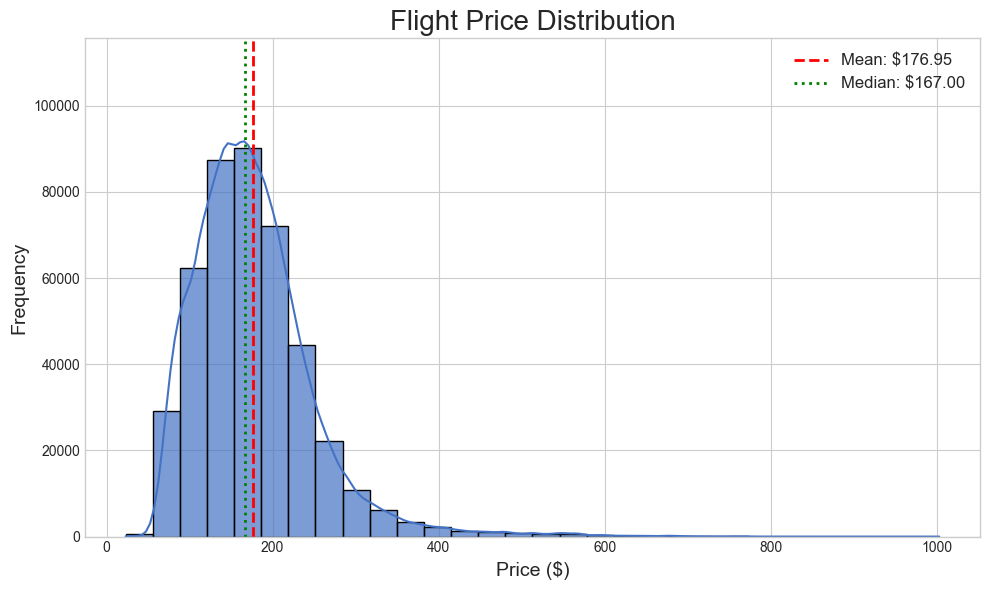

In [16]:
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(10, 6))
plt.title('Flight Price Distribution', fontsize=20)

sns.histplot(data['price'], bins=30, kde=True, color='#4472C4', 
             edgecolor='black', alpha=0.7)

mean_price = data['price'].mean()
median_price = data['price'].median()
plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${mean_price:.2f}')
plt.axvline(median_price, color='green', linestyle=':', linewidth=2, 
            label=f'Median: ${median_price:.2f}')

plt.ylim(0, plt.ylim()[1] * 1.2)

plt.xlabel('Price ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

visualizing price per company

In [17]:
from scipy.stats import skew, kurtosis
display(kurtosis(data['price']))
skew(data['price'])

np.float64(6.22985229583405)

np.float64(1.7049776125112948)

In [18]:
data_value_counts = data['to_dest_company'].value_counts()
data_value_counts = pd.DataFrame(data_value_counts).style.background_gradient("cool")
data_value_counts

,count
to_dest_company,
easyJet,121360
Vueling,97014
Ryanair,76422
Wizz Air,34636
ITA Airways,26677
British Airways,26492
Transavia France,18721
Air France,12428
Wizz Air Malta,10191


alot of rare and duplicate companies, lets remove them

In [19]:
company_mapping = {
    'Wizz Air Malta': 'Wizz Air',
    'Wizz Air UK': 'Wizz Air',
    'Ryanair UK': 'Ryanair',
    'Multiple airlines': 'Other',
    'Scandinavian Airlines': 'SAS',
    'KM Malta Airlines': 'Other',
    'Aeroitalia': 'Other',
    'FlixBus': 'Other',
    'BlaBlaBus': 'Other',
    'Union Ivkoni': 'Other',
    'Brussels Airlines': 'Other',
    'SWISS': 'Other',
    'Volotea': 'Other'
}

data['to_dest_company'] = data['to_dest_company'].replace(company_mapping)
data['return_company'] = data['return_company'].replace(company_mapping)

visualize dist of price per airway company (outbound and return)

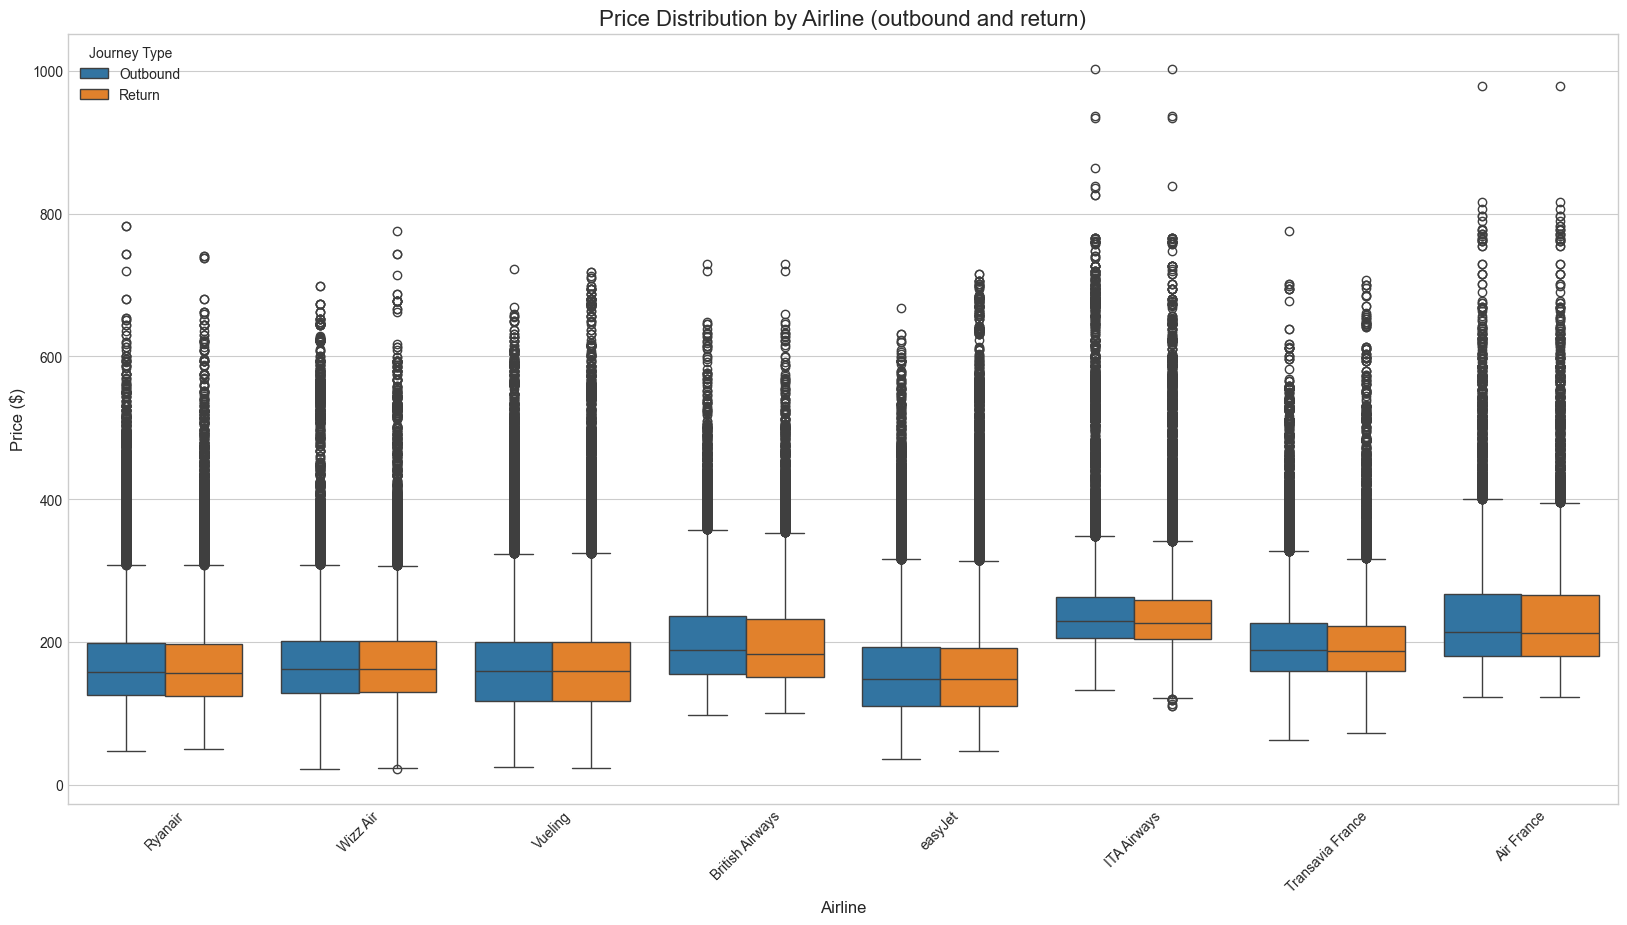

In [20]:
plt.figure(figsize=(20, 10))

outbound_data = data[['price', 'to_dest_company']].copy()
outbound_data['journey_type'] = 'Outbound'
outbound_data.rename(columns={'to_dest_company': 'company'}, inplace=True)

return_data = data[['price', 'return_company']].copy()
return_data['journey_type'] = 'Return'
return_data.rename(columns={'return_company': 'company'}, inplace=True)

combined_data = pd.concat([outbound_data, return_data])

# Get the top 10 most frequent airlines
top_airlines = combined_data['company'].value_counts().nlargest(8).index.tolist()
combined_data_filtered = combined_data[combined_data['company'].isin(top_airlines)]

sns.boxplot(x='company', y='price', hue='journey_type', data=combined_data_filtered)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.title('Price Distribution by Airline (outbound and return)', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Journey Type')

now lets visualize the price per city (origin, destination anf total route)

In [21]:
def price_per_feature(column: str):
    plt.figure(figsize=(20, 10))
    top_routes = data[column].value_counts().index.tolist()
    cities_data = data[data[column].isin(top_routes)]

    sns.boxplot(x= column, y='price', data=cities_data, palette='Set1')
    plt.title(f'Price by {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/277744366.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x= column, y='price', data=cities_data, palette='Set1')


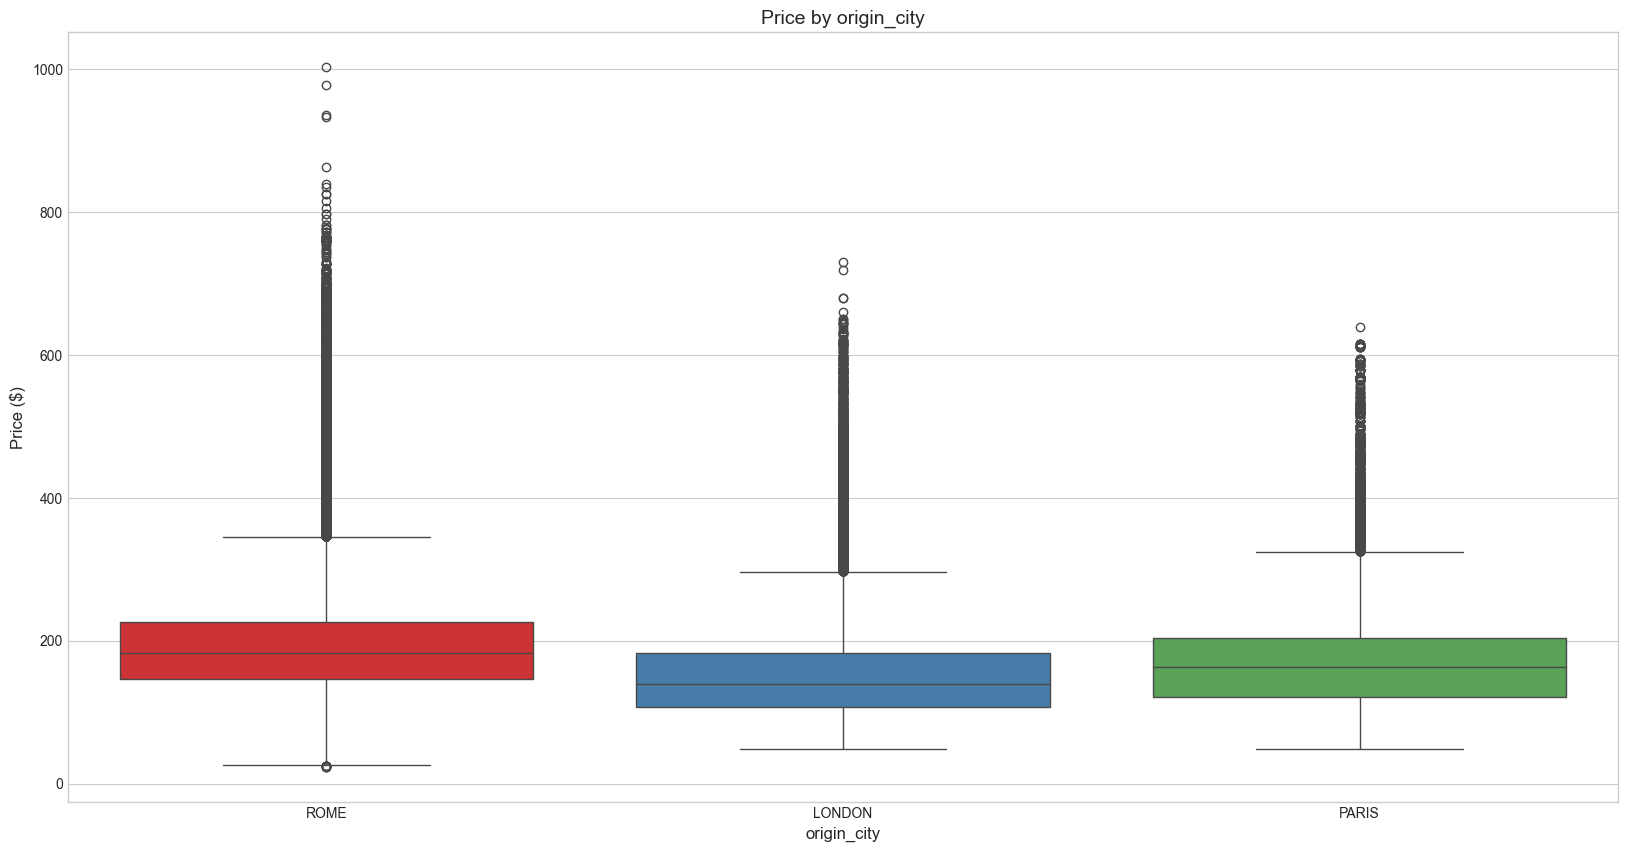

In [22]:
price_per_feature('origin_city')

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/277744366.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x= column, y='price', data=cities_data, palette='Set1')


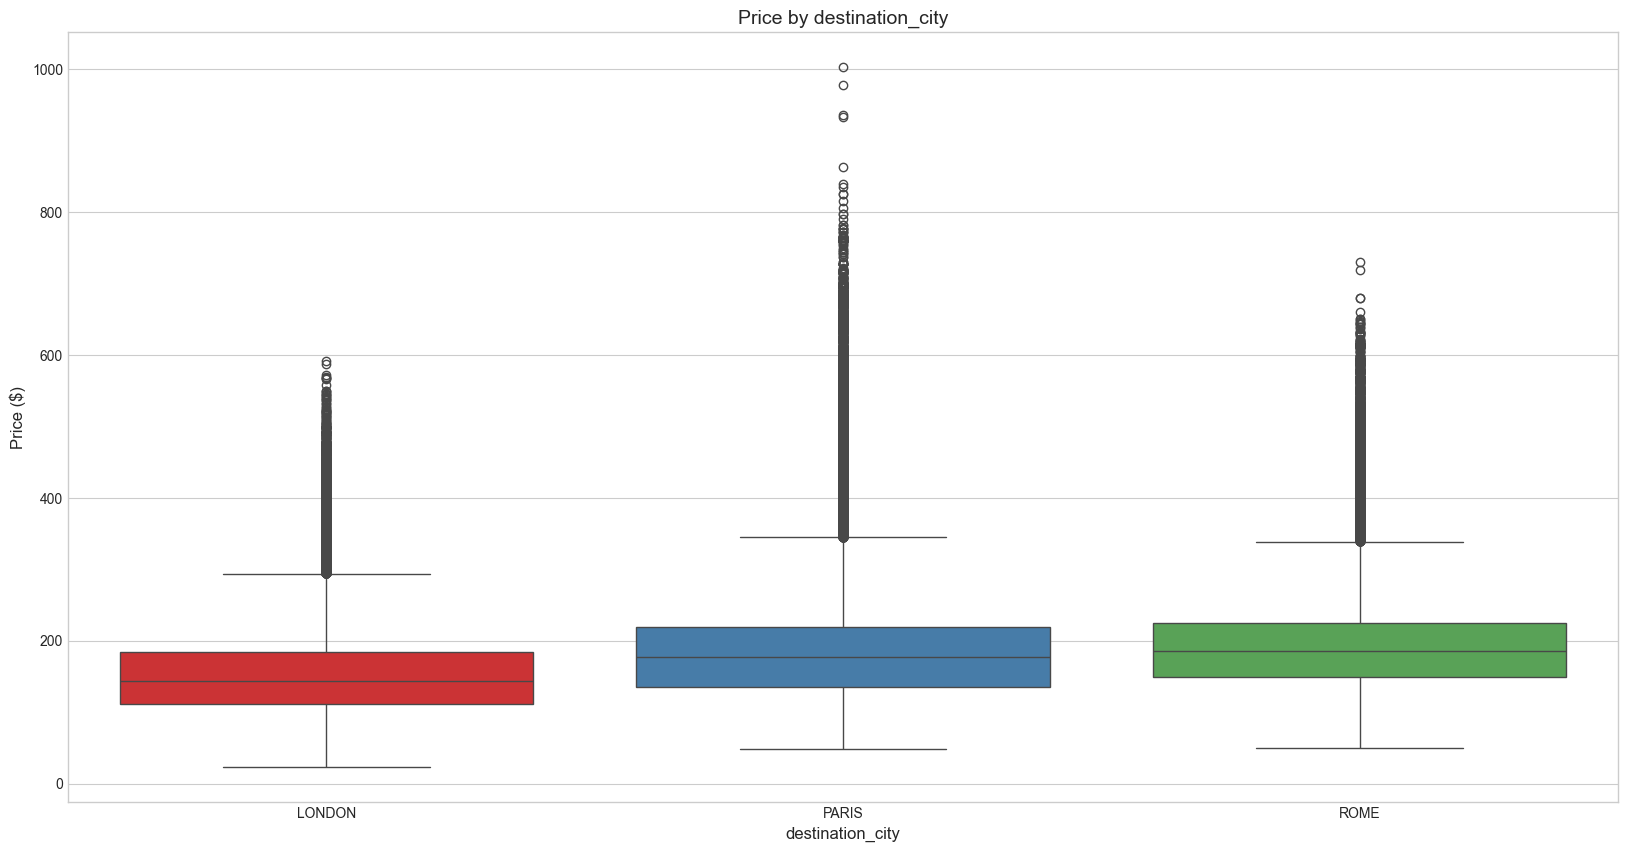

In [23]:
price_per_feature('destination_city')

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/277744366.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x= column, y='price', data=cities_data, palette='Set1')


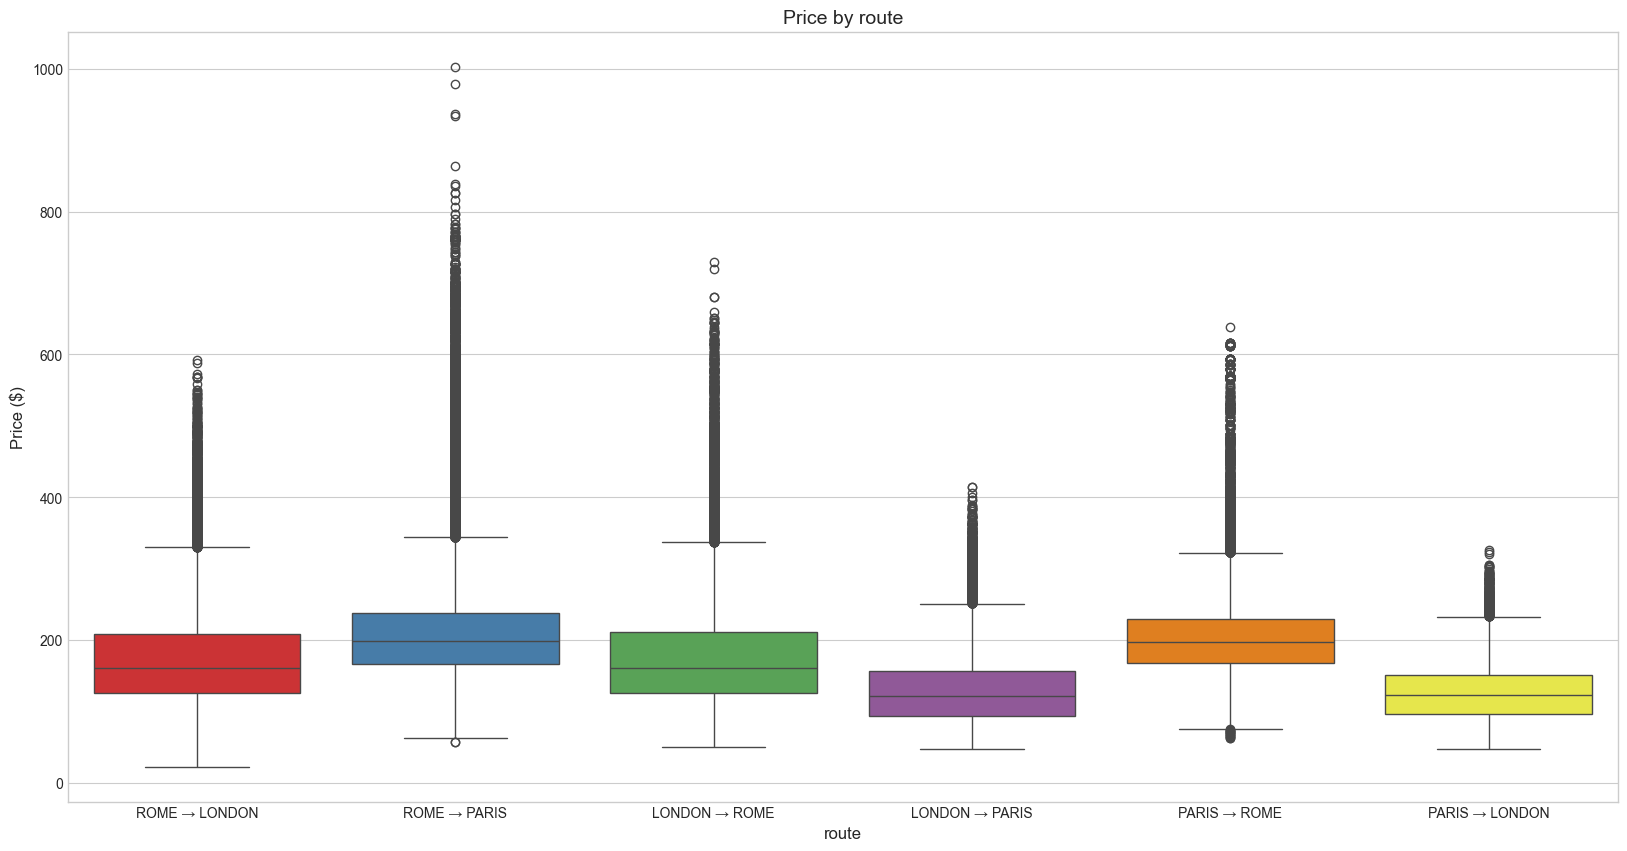

In [24]:
price_per_feature('route')

### Insights
- Rome is the most expensive distination to fly from and to, We can infer that the reason for the higher prices in Rome come from the fact that it is the most toured (trip with rome as destination is much more common then a trip with rome as outbound)
- the route of london to paris (and paris to london) is the cheapest, we can infer it because these cities are close to each other

### let check out the companies 

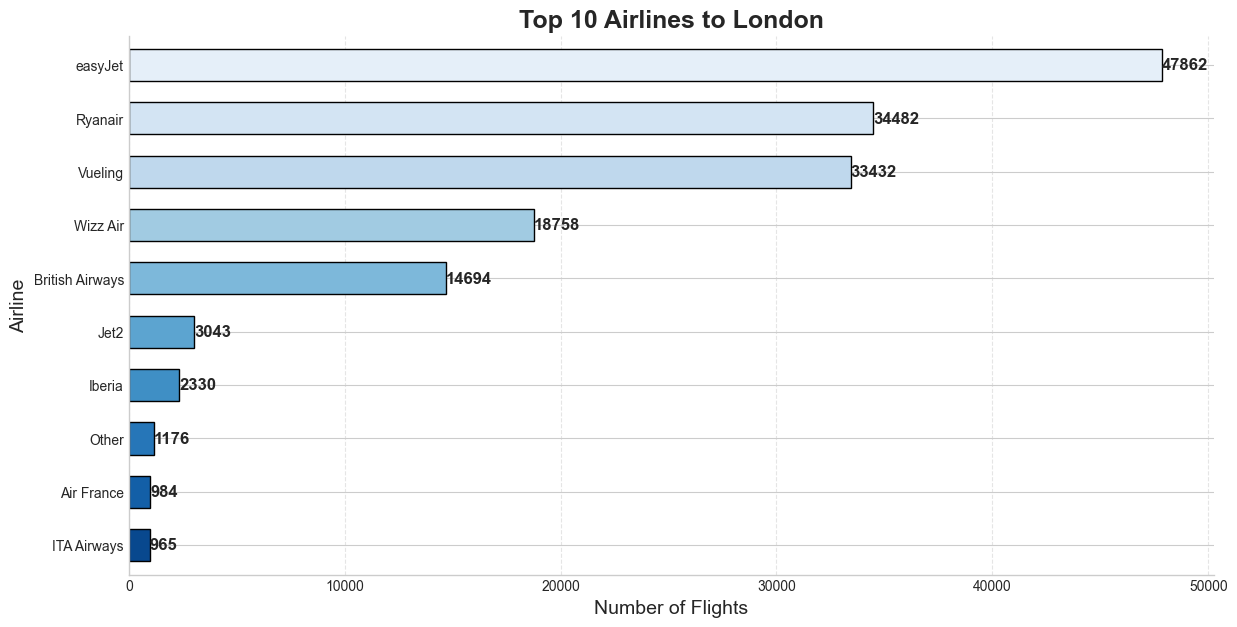

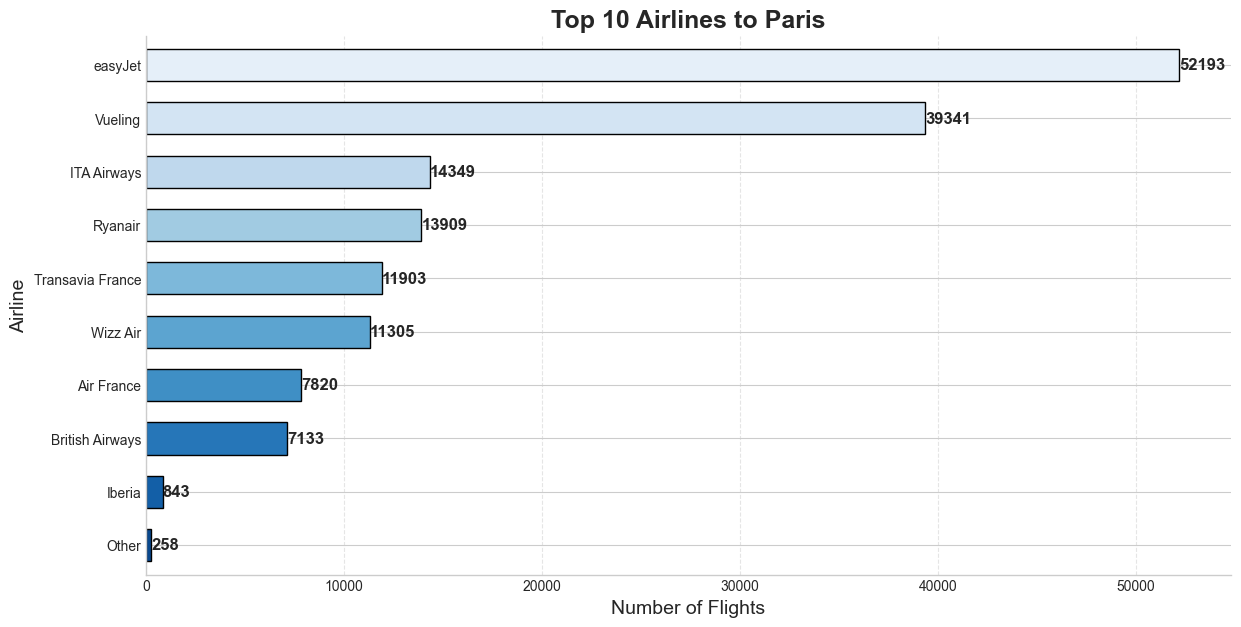

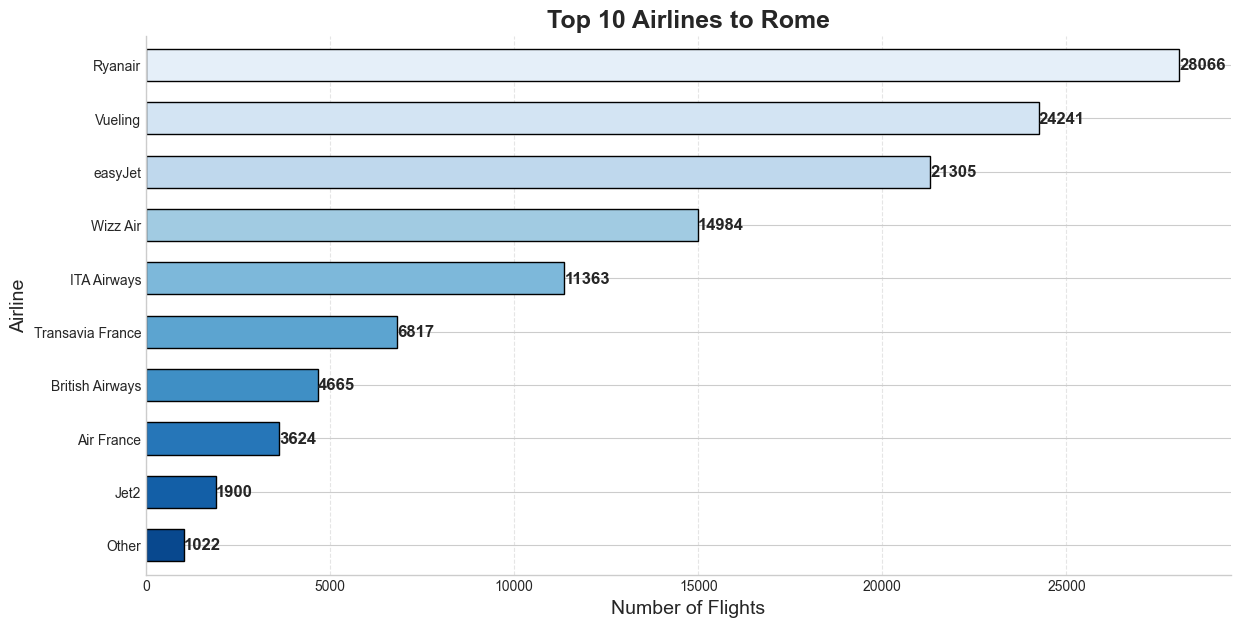

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better visualization
sns.set_style("whitegrid")

def flight_count(data):
    flight_counts = data.groupby(["destination_city", "to_dest_company"]).size().unstack().fillna(0)

    # Get the top 5 airlines with the most flights for each destination
    london_flights = flight_counts.loc["LONDON"].nlargest(10)
    paris_flights = flight_counts.loc["PARIS"].nlargest(10)
    rome_flights = flight_counts.loc["ROME"].nlargest(10)

    # Plot the results
    flights_counts(london_flights, "London")
    flights_counts(paris_flights, "Paris")
    flights_counts(rome_flights, "Rome")

def flights_counts(dest_flight_counts, dest):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot sorted bar chart
    bars = dest_flight_counts.sort_values(ascending=True).plot(
        kind="barh", 
        ax=ax, 
        edgecolor="black", 
        width=0.6,  # Reduce bar spacing
        color=sns.color_palette("Blues_r", len(dest_flight_counts))
    )

    # Improve aesthetics
    ax.set_title(f"Top 10 Airlines to {dest}", fontsize=18, fontweight="bold")
    ax.set_xlabel("Number of Flights", fontsize=14)
    ax.set_ylabel("Airline", fontsize=14)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add value labels
    for bar in bars.patches:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{int(bar.get_width())}', 
                ha='left', va='center', fontsize=12, fontweight="bold")

    plt.show()

# Call the function
flight_count(data)


destination

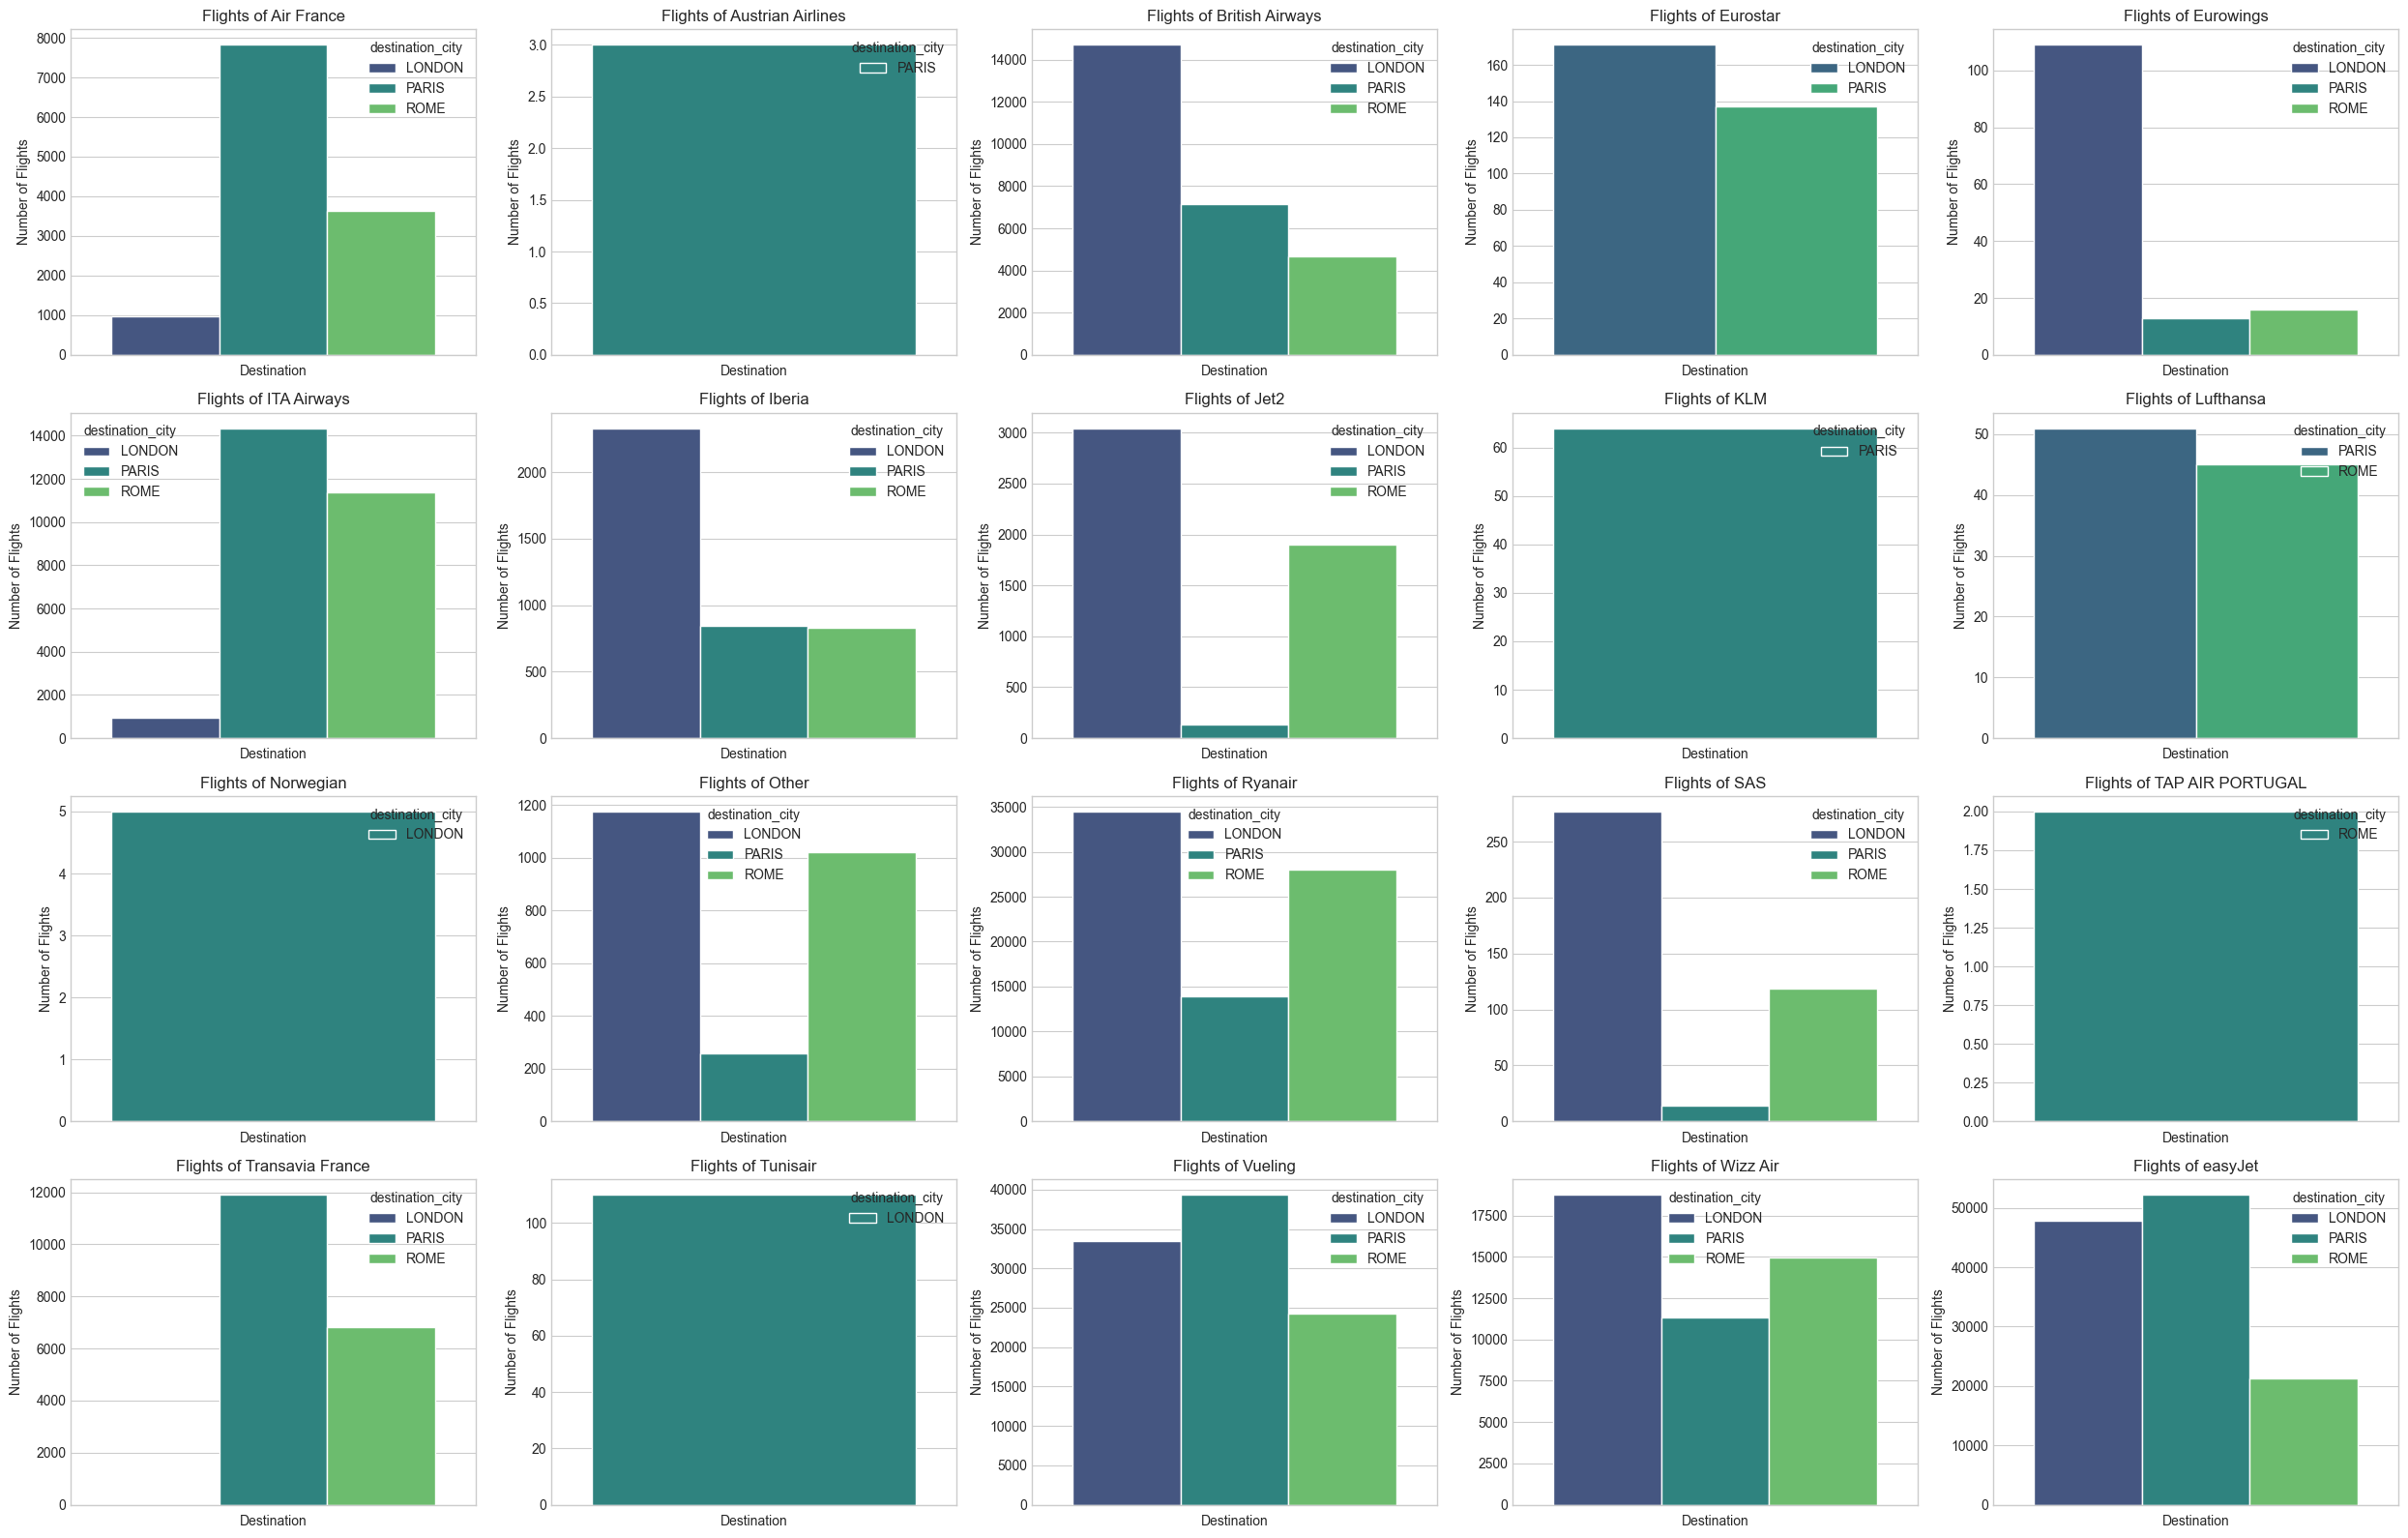

In [26]:
# Group data by flight company and destination, then count flights
flight_counts = data.groupby(['to_dest_company', 'destination_city']).size().reset_index(name='count')

# Get unique airlines
airlines = flight_counts['to_dest_company'].unique()
num_airlines = len(airlines)
num_rows = int(np.ceil(num_airlines / 5))

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
axes = axes.flatten()

# Plot barplot for each airline
for i, airline in enumerate(airlines):
    subset = flight_counts[flight_counts['to_dest_company'] == airline]
    sns.barplot(hue='destination_city', y='count', data=subset, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Flights of {airline}')
    axes[i].set_xlabel('Destination')
    axes[i].set_ylabel('Number of Flights')

# Hide extra subplots
for i in range(len(airlines), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



origin

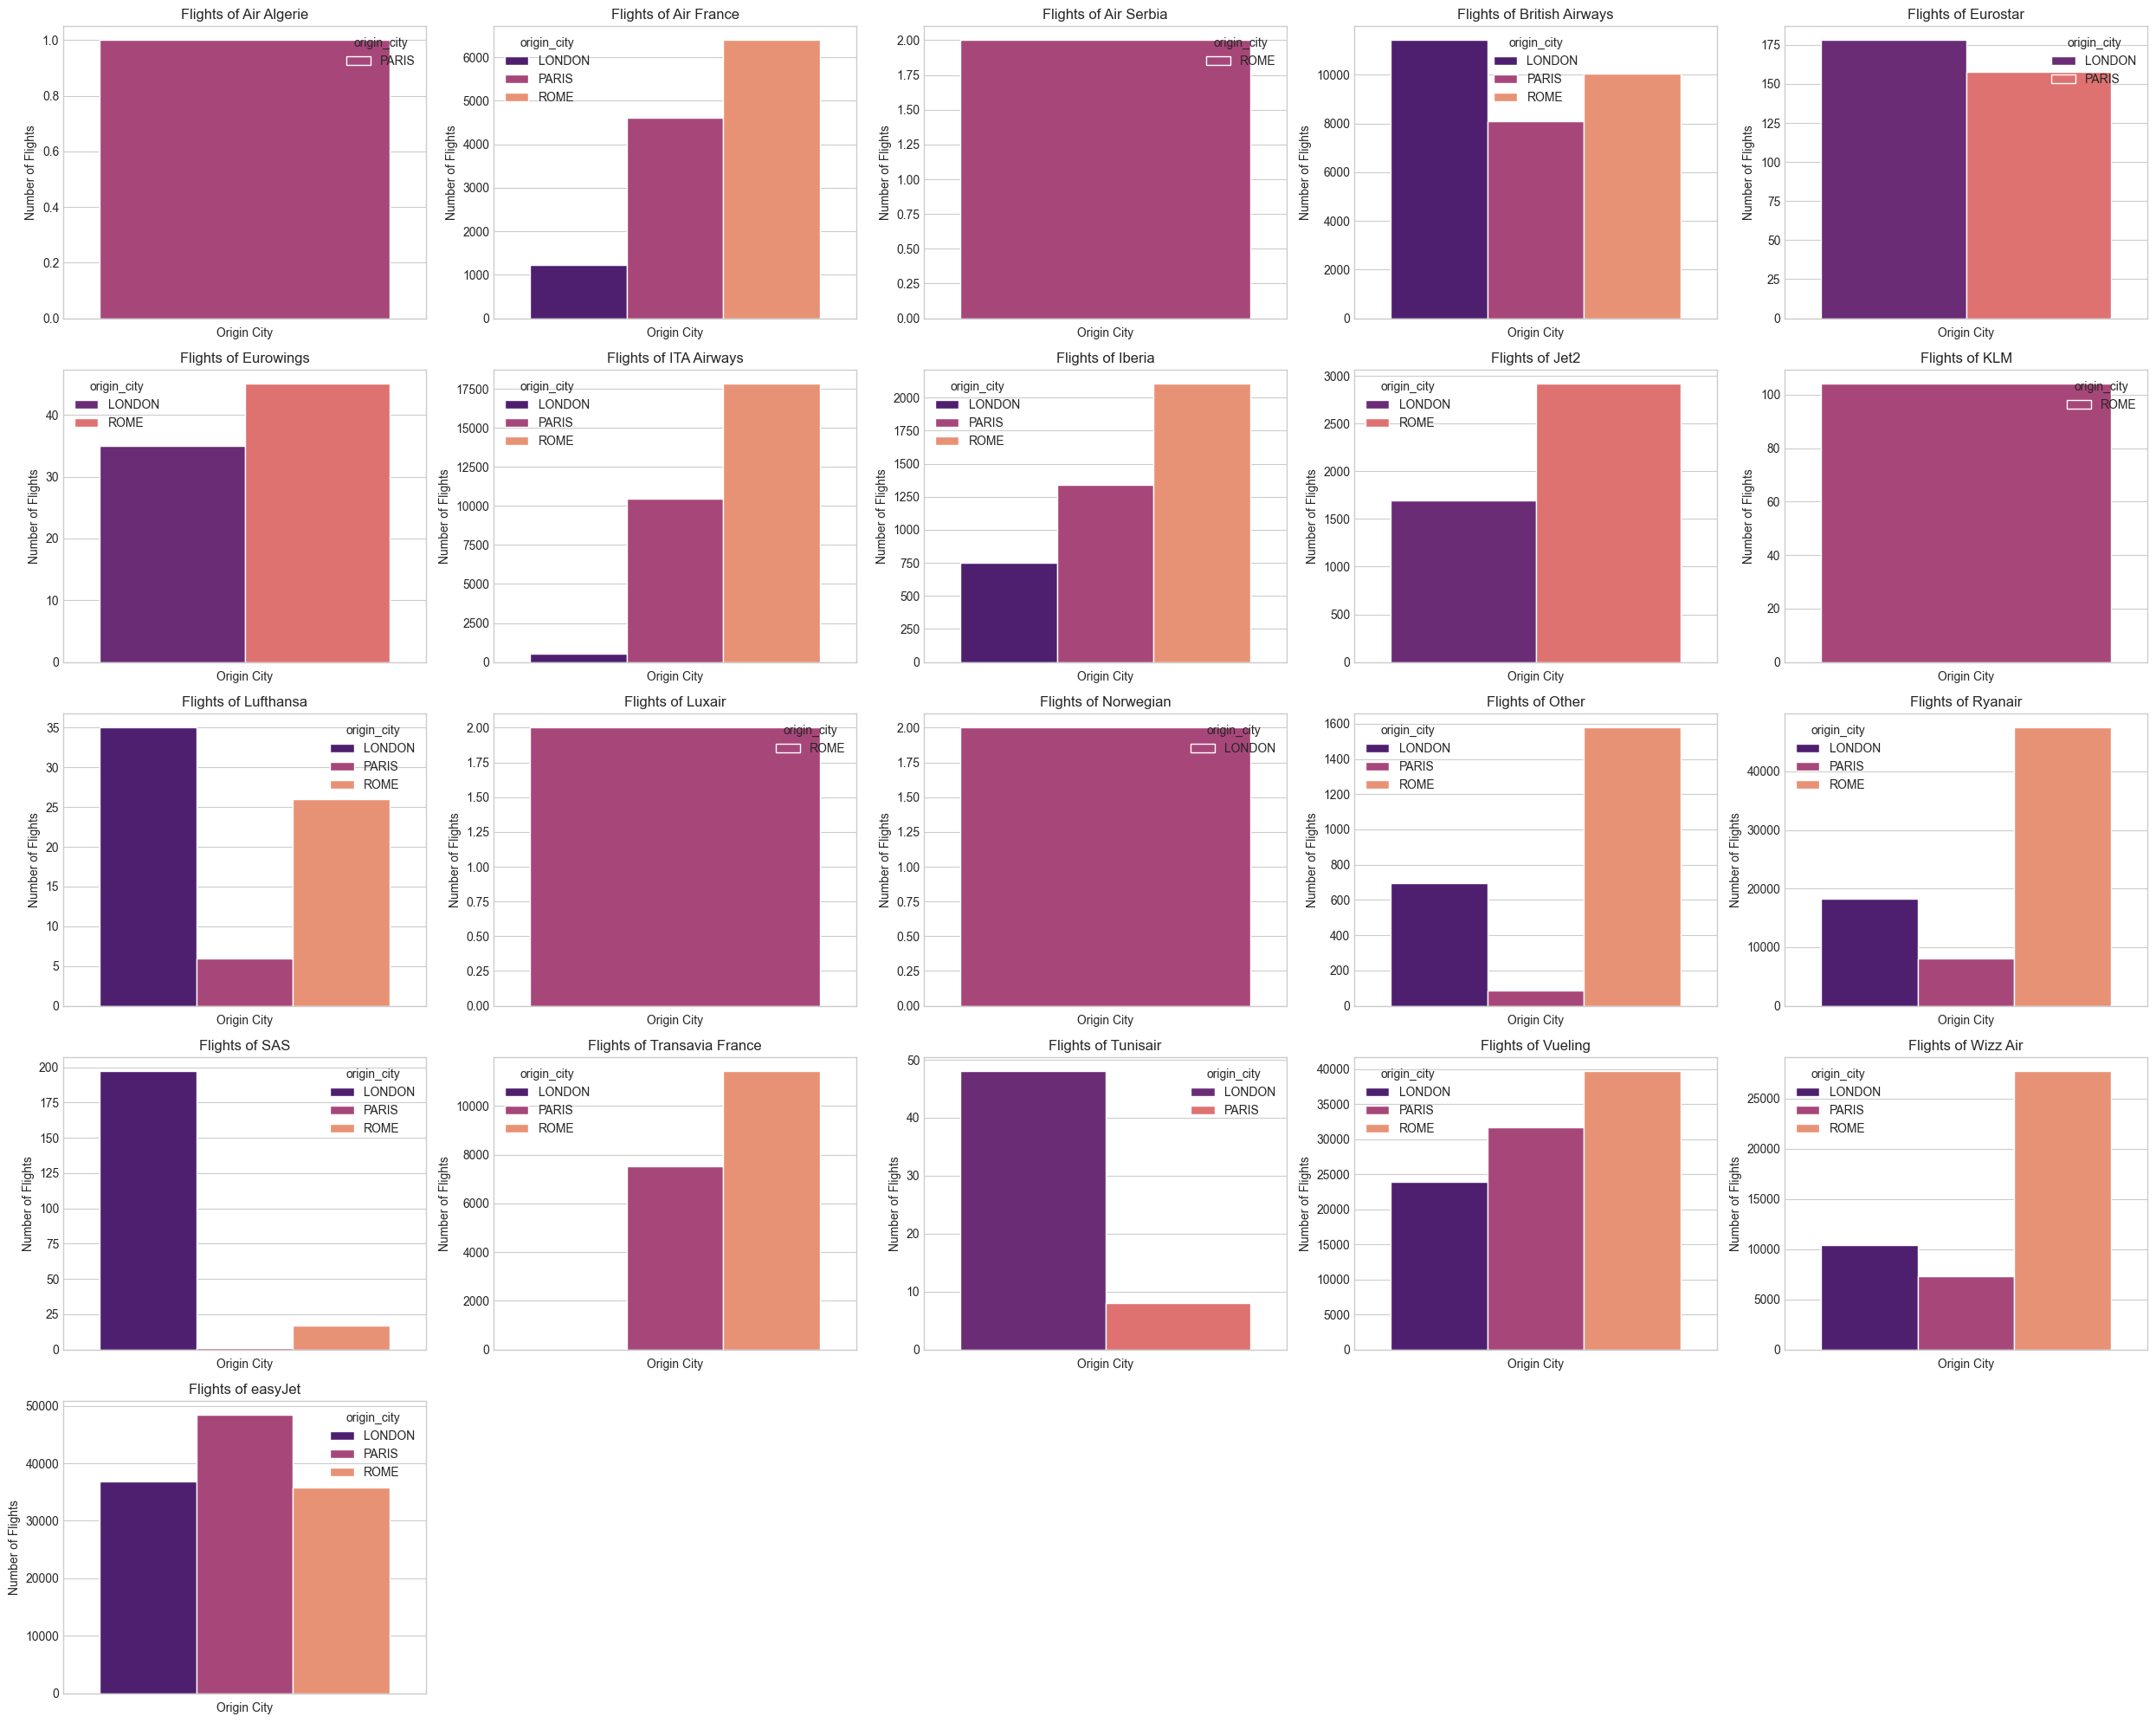

In [27]:
# Group data by flight company and destination, then count flights
flight_counts = data.groupby(['return_company', 'origin_city']).size().reset_index(name='count')

# Get unique airlines
airlines = flight_counts['return_company'].unique()
num_airlines = len(airlines)
num_rows = int(np.ceil(num_airlines / 5))

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
axes = axes.flatten()

# Plot barplot for each airline
for i, airline in enumerate(airlines):
    subset = flight_counts[flight_counts['return_company'] == airline]
    sns.barplot(hue='origin_city', y='count', data=subset, ax=axes[i], palette='magma')
    axes[i].set_title(f'Flights of {airline}')
    axes[i].set_xlabel('Origin City')
    axes[i].set_ylabel('Number of Flights')

# Hide extra subplots
for i in range(len(airlines), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Insights
- we can infer that there is a strong corelation between the airway company and the destination city

### Weekdats

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/2116550486.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_of_week', y='price', data=data, order=week_order, palette='flare')


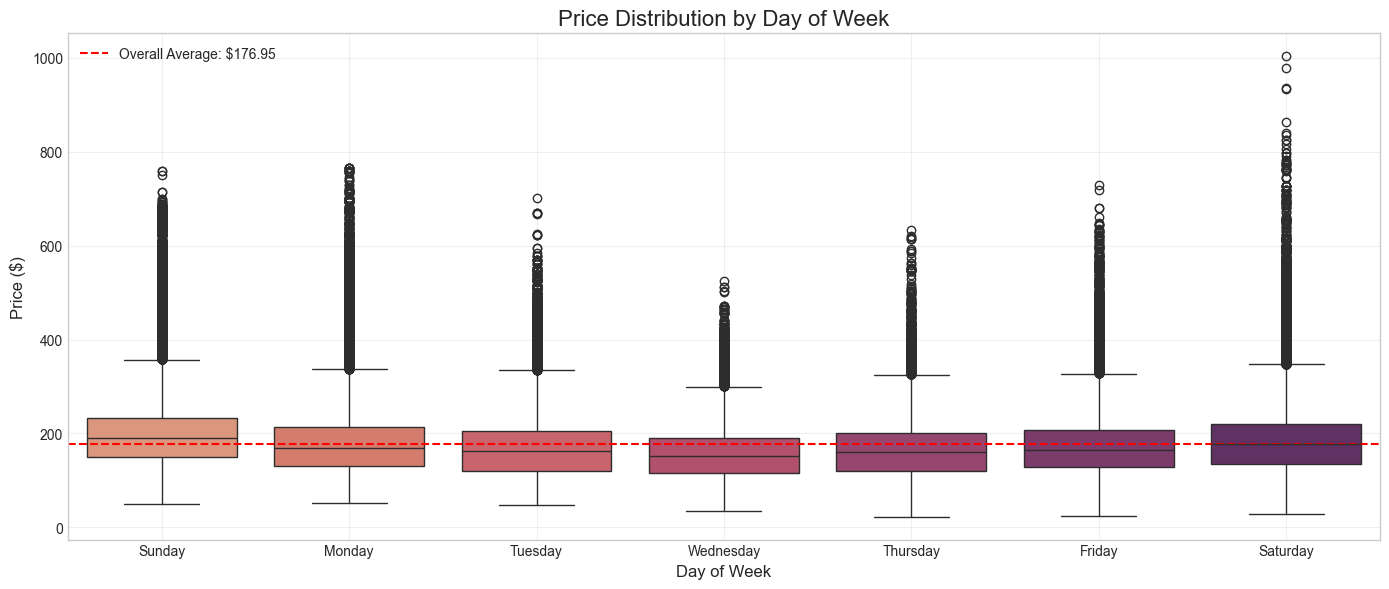

In [28]:
week_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    
fig = plt.figure(figsize=(14, 6))

sns.boxplot(x='day_of_week', y='price', data=data, order=week_order, palette='flare')
plt.title('Price Distribution by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add average line
plt.axhline(y=data['price'].mean(), color='r', linestyle='--', 
            label=f'Overall Average: ${data["price"].mean():.2f}')
plt.legend()

plt.tight_layout()

### Insights
- on weekend (chrisitan: sunday, saturday) the prices are higher then in the middle of the week (wednesday)
- in saturday the mean is equal to the median and has the largest outlier (prob the most popular so the prices are normlized and has the largest supply)

### Layovers

#### outbound layover

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/259240557.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='destination_city', y='layover_time', data=layover_data, palette='cubehelix')


,Mean Layover,Median Layover,Min Layover,Max Layover,Layover Std Dev
destination_city,,,,,
LONDON,5.35,0.0,0,1335,37.14
PARIS,5.46,0.0,0,1495,42.59
ROME,8.33,0.0,0,1245,45.48


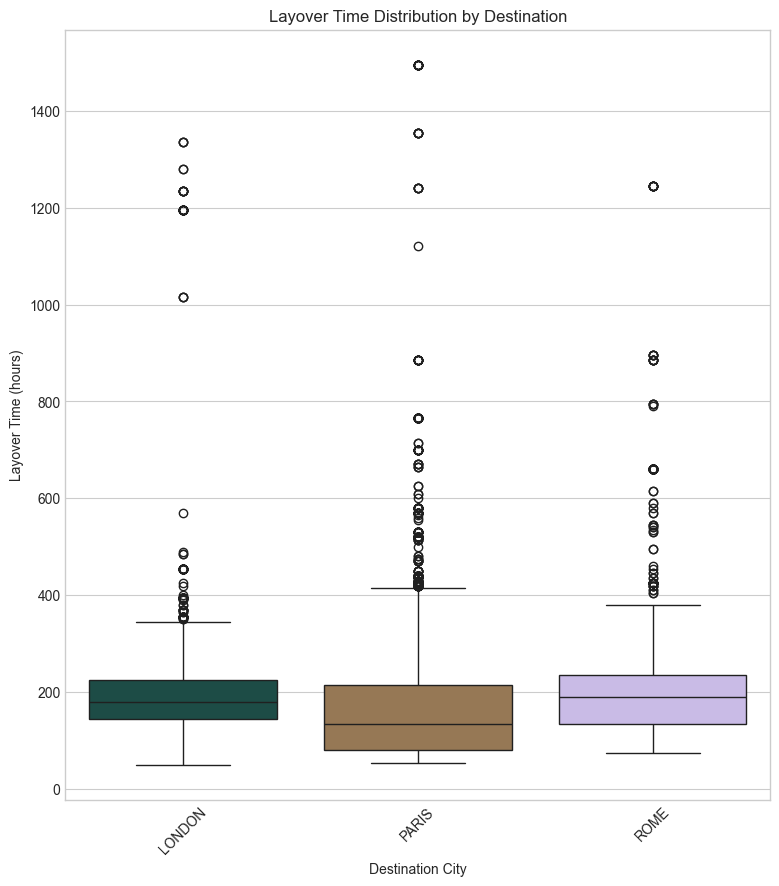

In [29]:
layover_data = data[data['layover']== True]
layover_data = layover_data[layover_data['layover_time'] > 0]
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.boxplot(x='destination_city', y='layover_time', data=layover_data, palette='cubehelix')
plt.title('Layover Time Distribution by Destination')
plt.xlabel('Destination City')
plt.ylabel('Layover Time (hours)')
plt.xticks(rotation=45)

# Calculate summary statistics
data.groupby('destination_city')['layover_time'].agg([
    ('Mean Layover', 'mean'),
    ('Median Layover', 'median'),
    ('Min Layover', 'min'),
    ('Max Layover', 'max'),
    ('Layover Std Dev', 'std')
]).round(2)


if there is a layover, price dist over time of layover per dest

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/4118066904.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='destination_city', y='return_layover_time', data=layover_data, palette='icefire')


,Mean Layover,Median Layover,Min Layover,Max Layover,Layover Std Dev
destination_city,,,,,
LONDON,5.73,0.0,0,1245,38.10
PARIS,4.82,0.0,0,1495,35.58
ROME,6.77,0.0,0,1495,44.00


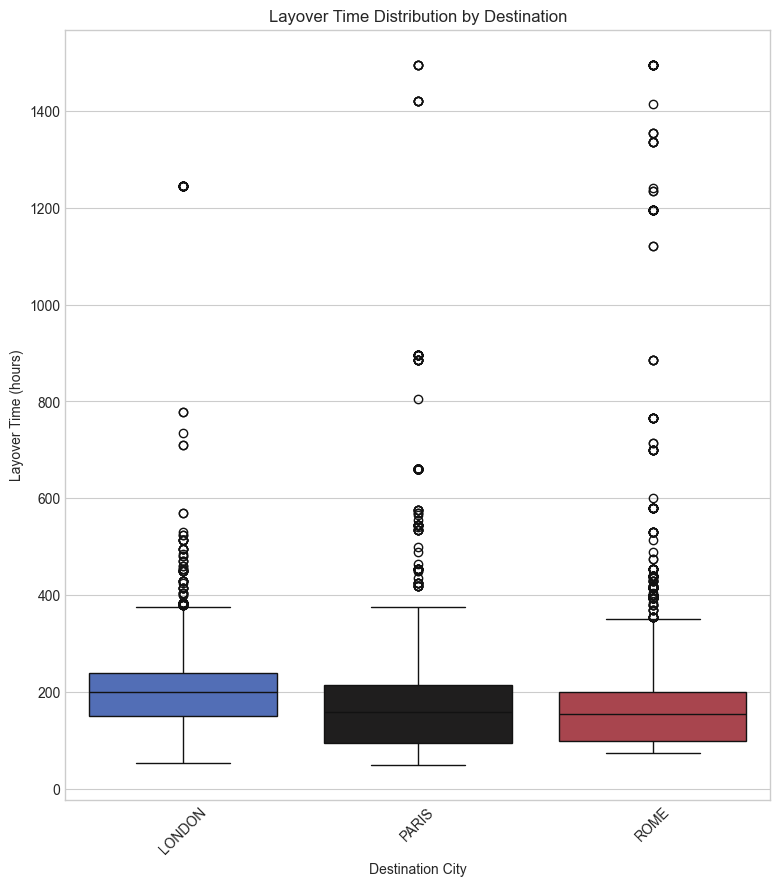

In [30]:
layover_data = data[data['layover']== True]
layover_data = layover_data[layover_data['return_layover_time'] > 0]
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.boxplot(x='destination_city', y='return_layover_time', data=layover_data, palette='icefire')
plt.title('Layover Time Distribution by Destination')
plt.xlabel('Destination City')
plt.ylabel('Layover Time (hours)')
plt.xticks(rotation=45)



# Calculate summary statistics
data.groupby('destination_city')['return_layover_time'].agg([
    ('Mean Layover', 'mean'),
    ('Median Layover', 'median'),
    ('Min Layover', 'min'),
    ('Max Layover', 'max'),
    ('Layover Std Dev', 'std')
]).round(2)

departure airport per city price influance

Mean Price  Median Price  Min Price  Max Price  \
origin_city departure_airport                                                   
LONDON      LCY                    261.68        225.00      135.0      562.0   
            LGW                    154.87        141.00       50.0      730.0   
            LHR                    170.91        157.25       70.0      639.0   
            LON                    173.05        162.00       56.0      374.0   
            LTN                    122.03        113.00       48.0      390.0   
            SEN                    118.95        112.00       59.0      326.0   
            STN                    162.92        149.00       51.0      680.0   
PARIS       BVA                    173.42        166.44       65.0      613.0   
            CDG                    155.88        142.36       48.0      616.0   
            ORY                    175.05        174.00       55.0      639.0   
            PAR                    169.86        174.00       50.0      276.0   
ROME        CIA                    160.52        151.00       48.0      516.0   
            FCO                    202.62        189.00       23.0     1003.0   

                               Price Std Dev  Number of Flights  
origin_city departure_airport                                    
LONDON      LCY                        89.84                291  
            LGW                        66.97              52998  
            LHR                        68.98              12710  
            LON                        46.19                139  
            LTN                        43.61              17039  
            SEN                        38.50               1335  
            STN                        69.79              21643  
PARIS       BVA                        48.44               8691  
            CDG                        65.60              50074  
            ORY                        58.33              68736  
            PAR                        39.10                175  
ROME        CIA                        56.41              34572  
            FCO                        79.97             168470

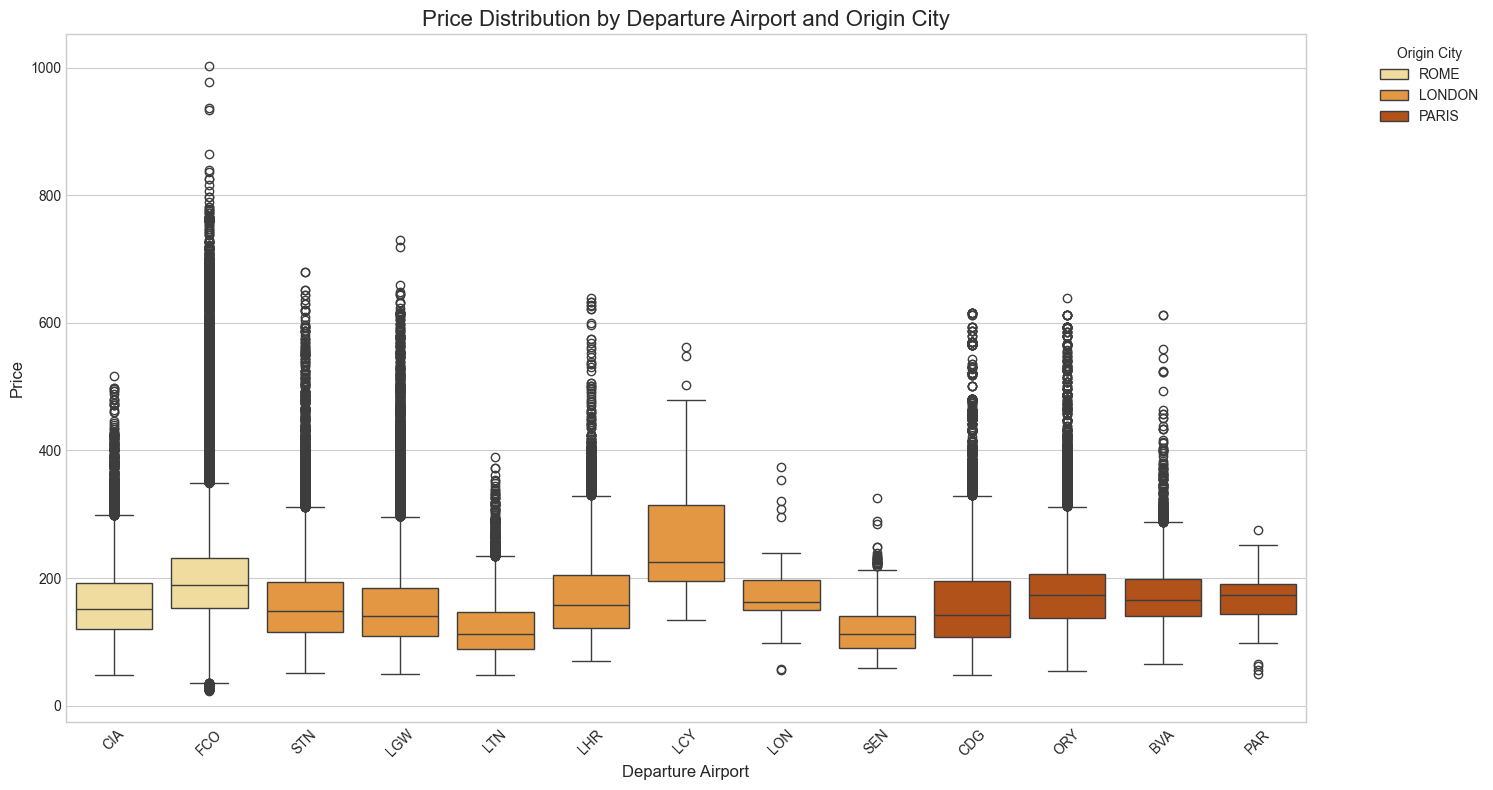

In [31]:
plt.figure(figsize=(15, 8))
    
# Create a box plot to show price distribution by departure airport for each origin city
sns.boxplot(x='departure_airport', y='price', hue='origin_city', data=data ,palette='YlOrBr')

plt.title('Price Distribution by Departure Airport and Origin City', fontsize=16)
plt.xlabel('Departure Airport', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Origin City', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent cutting off labels
plt.tight_layout()


# Calculate summary statistics
data.groupby(['origin_city', 'departure_airport'])['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Number of Flights', 'count')
]).round(2)

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/2751500551.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_category', y='price', data=data, palette='cubehelix')


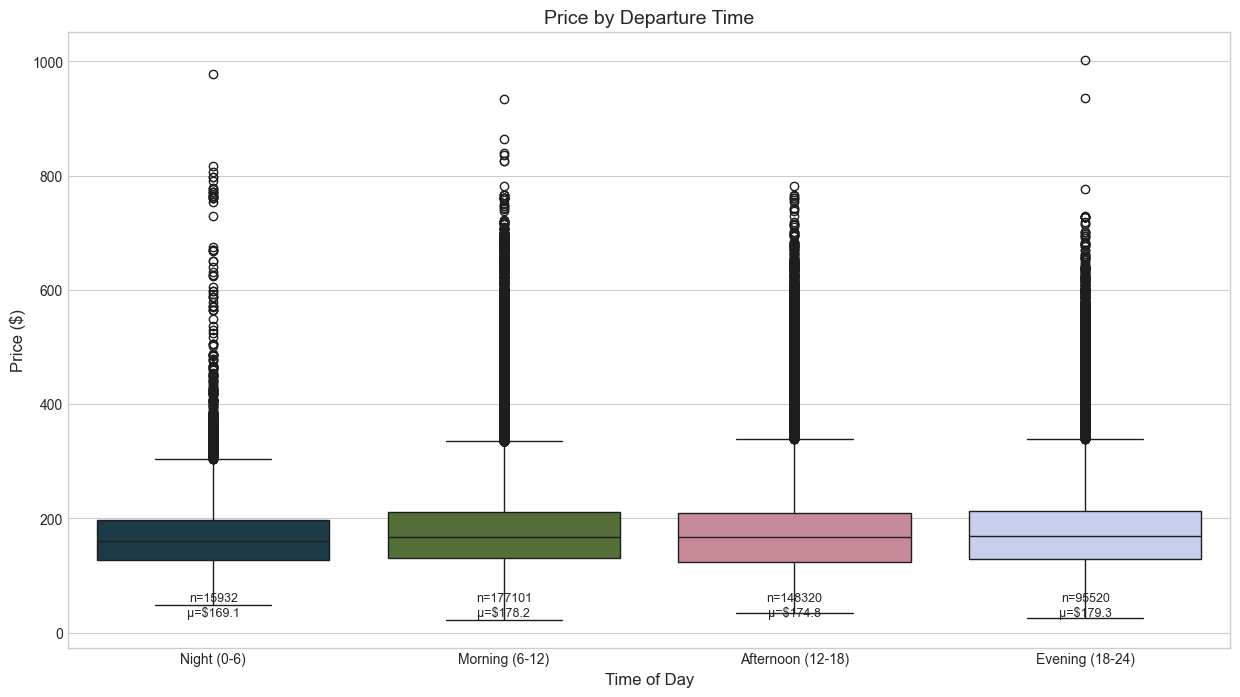

In [32]:
plt.figure(figsize=(15, 8))

# Create time categories
data['time_category'] = pd.cut(
    data['departure_hour'], 
    bins=[0, 6, 12, 18, 24],
    labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)']
)

sns.boxplot(x='time_category', y='price', data=data, palette='cubehelix')
plt.title('Price by Departure Time', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)

# Add count and mean annotations
for i, category in enumerate(data['time_category'].cat.categories):
    count = data[data['time_category'] == category].shape[0]
    mean = data[data['time_category'] == category]['price'].mean()
    plt.annotate(f'n={count}\nμ=${mean:.1f}', 
                        xy=(i, data['price'].min()), 
                        ha='center', va='bottom', fontsize=9)

evening and afternoon almost identical

### Remove the outlier (Tukey method: 1.5*IQR)

In [33]:
def remove_route_outliers(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return group[(group['price'] >= lower_bound) & 
                        (group['price'] <= upper_bound)]

#### Lets visualize before and after removing the outlier (price over route)

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/3009661576.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned = data.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)


Original DataFrame size: 436873
Cleaned DataFrame size: 422049
Number of outliers removed: 14824
Percentage of data removed: 3.39%


/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/3009661576.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='route', y='price', data=data, palette='viridis')
/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_13973/3009661576.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='route', y='price', data=data_cleaned, palette='magma')



Price Statistics - Original Data:
                Mean Price  Median Price  Min Price  Max Price  Price Std Dev  \
route                                                                           
LONDON → PARIS      129.95        122.00       48.0      414.0          46.90   
LONDON → ROME       177.38        161.00       50.0      730.0          74.78   
PARIS → LONDON      126.42        122.74       48.0      326.0          38.53   
PARIS → ROME        204.12        197.00       63.0      639.0          54.40   
ROME → LONDON       172.94        160.59       23.0      592.0          66.19   
ROME → PARIS        216.48        199.00       57.0     1003.0          82.38   

                Total Flights  
route                          
LONDON → PARIS          54515  
LONDON → ROME           51640  
PARIS → LONDON          60316  
PARIS → ROME            67360  
ROME → LONDON           98083  
ROME → PARIS           104959  

Price Statistics - Cleaned Data:
                Mean Price

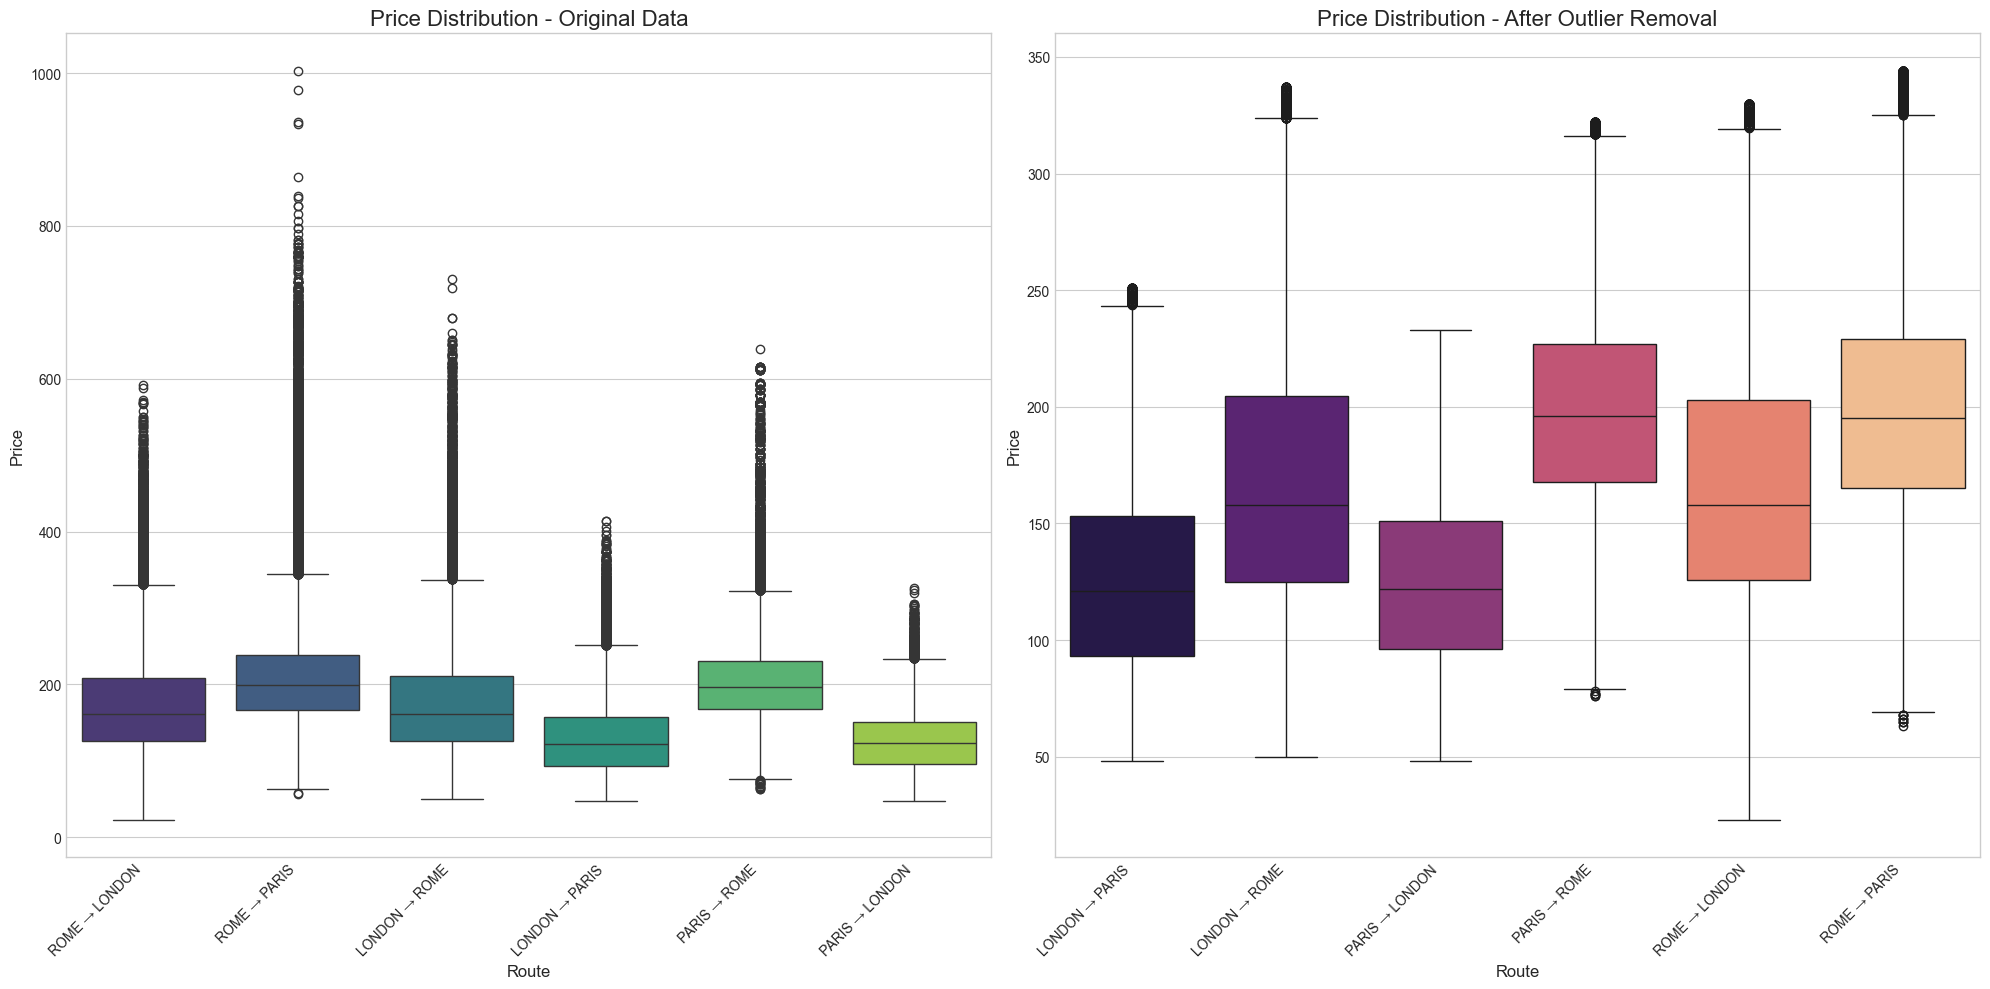

In [34]:

# Group by route and remove outliers
data_cleaned = data.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)

# Print removal statistics
original_count = len(data)
cleaned_count = len(data_cleaned)
removed_count = original_count - cleaned_count

print(f"Original DataFrame size: {original_count}")
print(f"Cleaned DataFrame size: {cleaned_count}")
print(f"Number of outliers removed: {removed_count}")
print(f"Percentage of data removed: {removed_count/original_count*100:.2f}%")

# Set up the figure with two subplots
plt.figure(figsize=(20, 10))

# Original Data Distribution
plt.subplot(1, 2, 1)
sns.boxplot(x='route', y='price', data=data, palette='viridis')
plt.title('Price Distribution - Original Data', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Cleaned Data Distribution
plt.subplot(1, 2, 2)
sns.boxplot(x='route', y='price', data=data_cleaned, palette='magma')
plt.title('Price Distribution - After Outlier Removal', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Adjust layout and save
plt.tight_layout()

# Additional statistical summary
print("\nPrice Statistics - Original Data:")
original_stats = data.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(original_stats)

print("\nPrice Statistics - Cleaned Data:")
cleaned_stats = data_cleaned.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(cleaned_stats)
data = data_cleaned

In [35]:
data.head()

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,return_landing_airport,return_company,price,layover,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time,day_of_week,route,time_category
0,17.583333,LHR,80,19.916667,CDG,Air France,18.0,CDG,80,18.333333,LHR,Air France,223.0,False,1,1,2025-02-28,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON → PARIS,Afternoon (12-18)
1,12.000000,LGW,75,14.250000,CDG,easyJet,7.0,CDG,80,7.333333,LTN,easyJet,191.0,False,1,1,2025-02-28,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON → PARIS,Morning (6-12)
2,12.750000,LGW,80,15.083333,ORY,Vueling,7.0,CDG,80,7.333333,LTN,easyJet,185.0,False,1,1,2025-02-28,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON → PARIS,Afternoon (12-18)
3,12.750000,LGW,80,15.083333,ORY,Vueling,7.0,ORY,70,7.166667,LGW,Vueling,201.0,False,1,1,2025-02-28,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON → PARIS,Afternoon (12-18)
4,12.750000,LGW,80,15.083333,ORY,Vueling,7.0,CDG,80,7.333333,LTN,easyJet,198.0,False,1,1,2025-02-28,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON → PARIS,Afternoon (12-18)


### Pairplot

<Figure size 2000x1600 with 0 Axes>

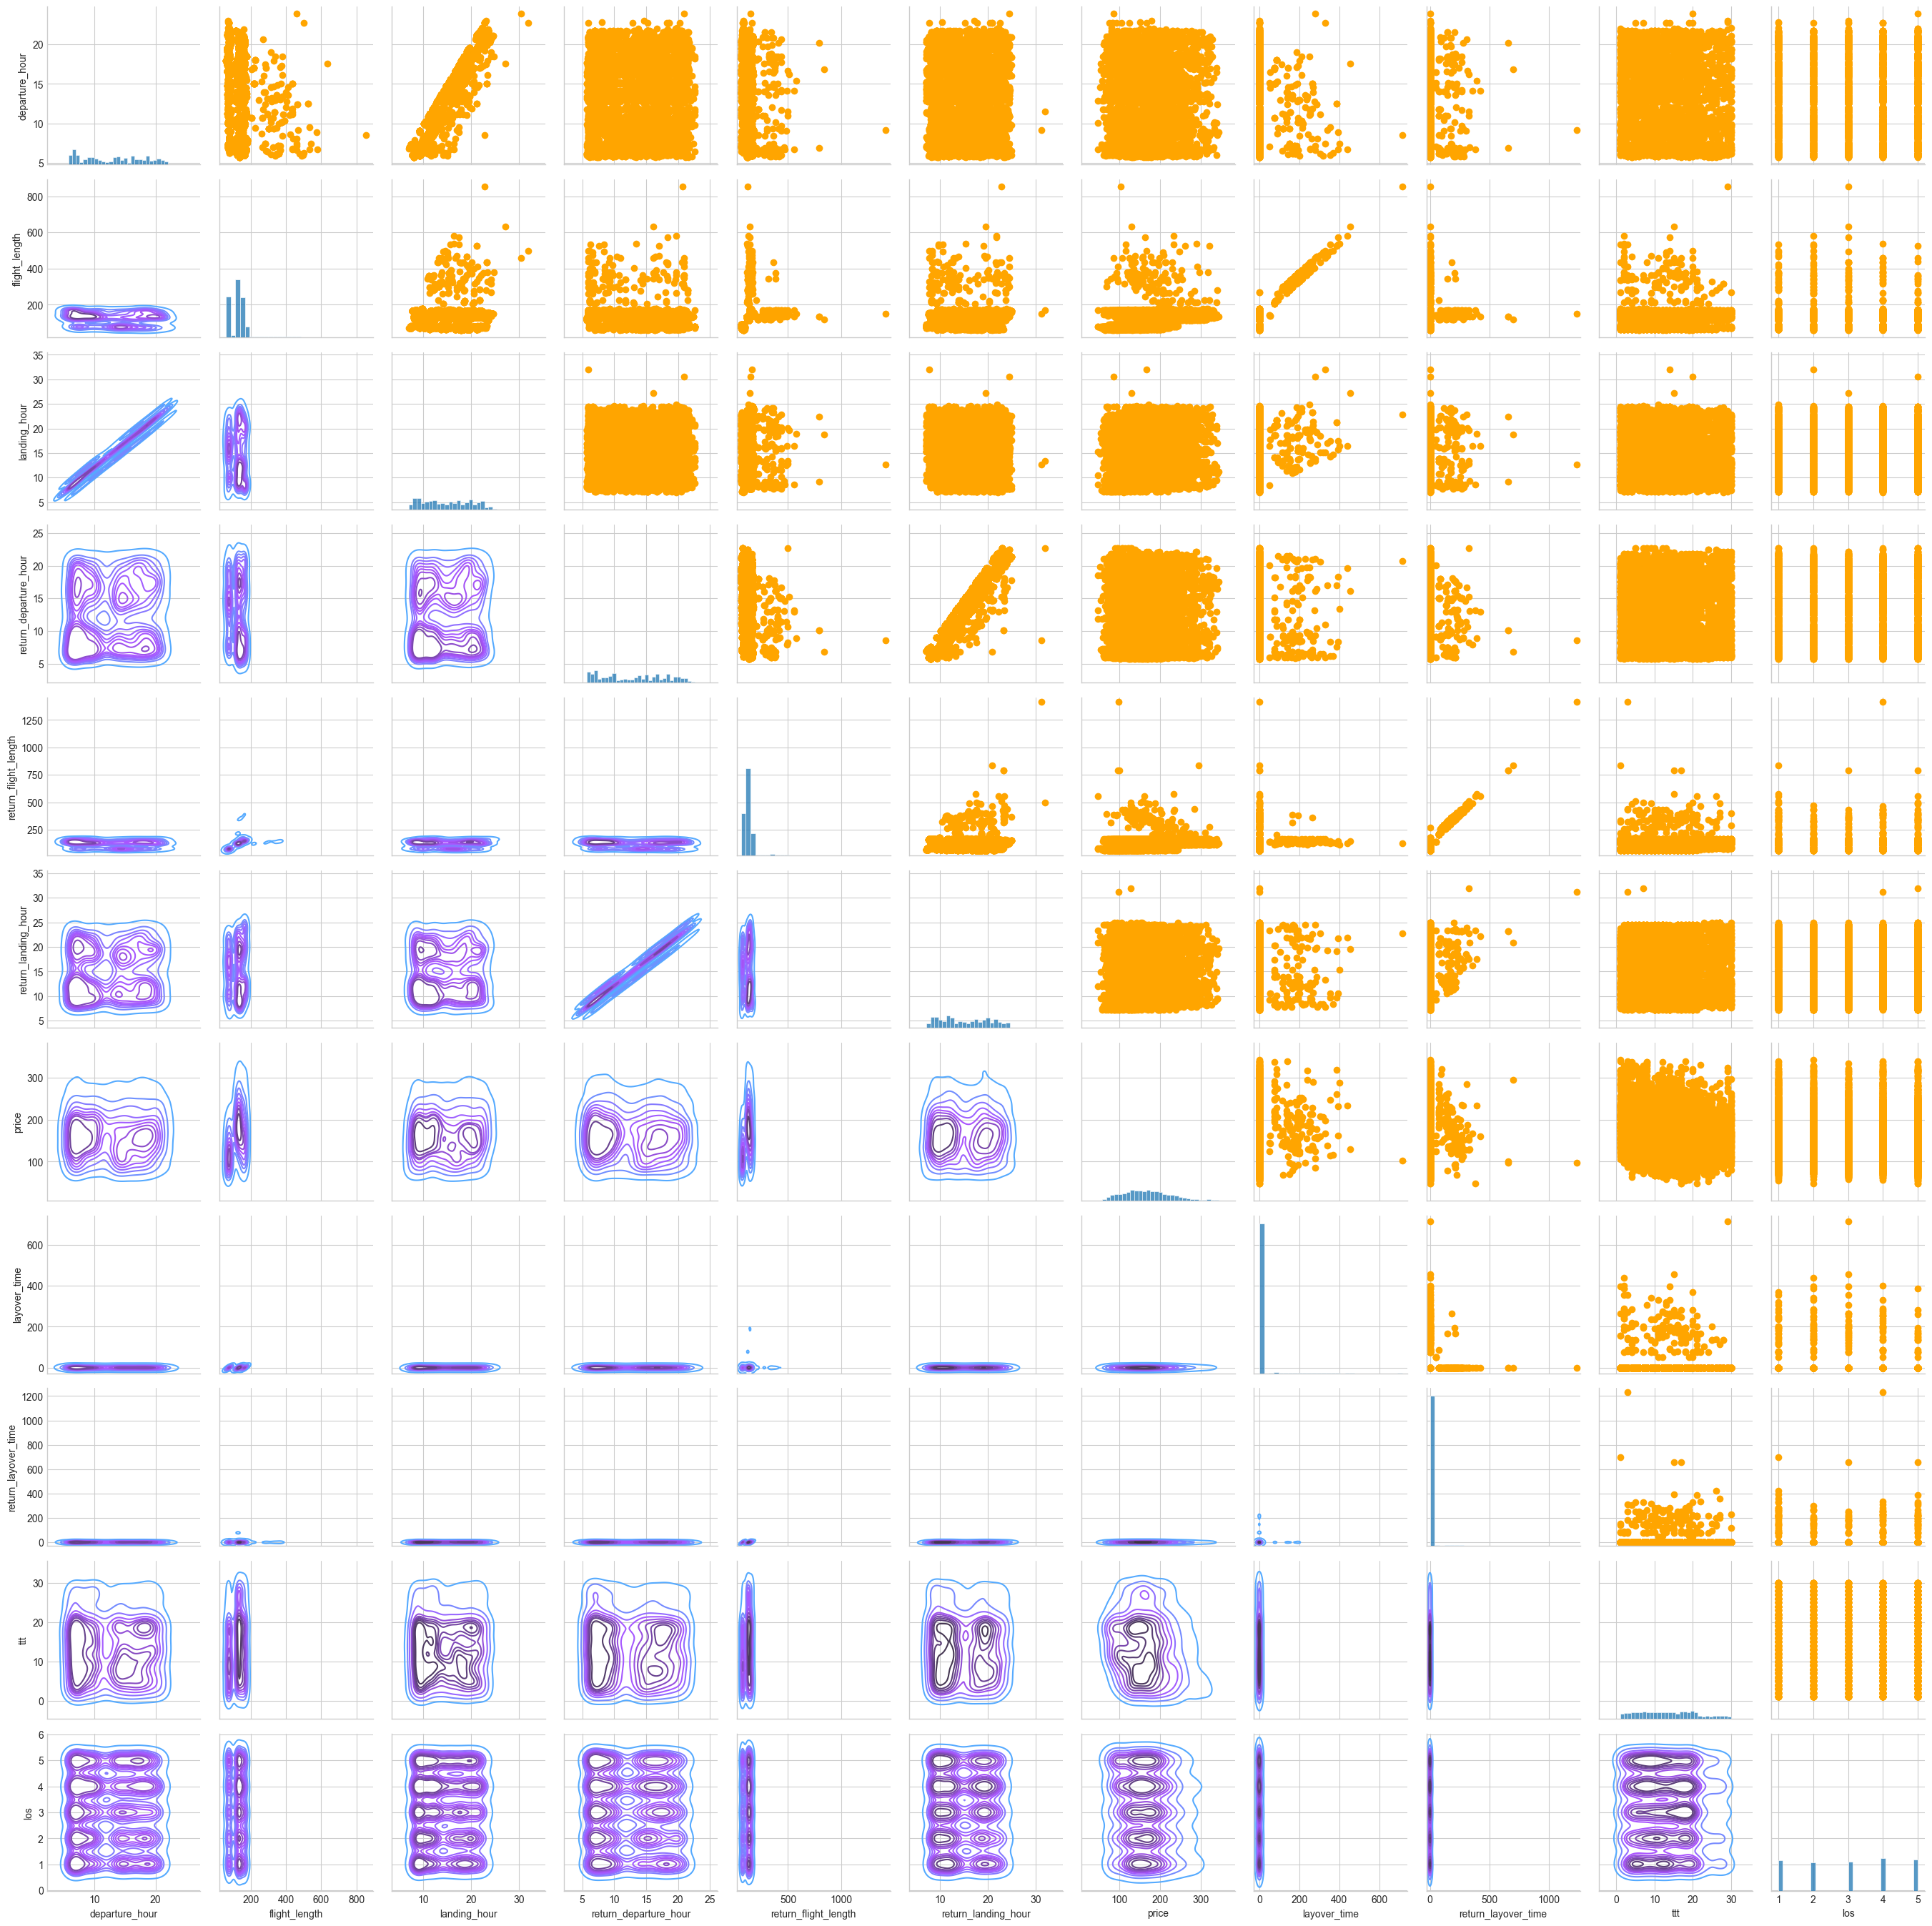

In [37]:
plt.figure(figsize=(20.0,16))
numeric_cols = ['departure_hour', 'flight_length', 'landing_hour', 
                'return_departure_hour', 'return_flight_length', 
                'return_landing_hour', 'price', 'layover_time', 
                'return_layover_time', 'ttt', 'los']
sampled_data = data.sample(5000, random_state=56476576)
pair_grid = sns.PairGrid(sampled_data[numeric_cols])
pair_grid.map_upper(plt.scatter,color='orange')
pair_grid.map_lower(sns.kdeplot,cmap='cool_d')
pair_grid.map_diag(sns.histplot,bins=30)
pair_grid.savefig('pairplot.png')

theres is a strong corolation between the layover time and the flight time (outbound and return)
also between the price and the flight lenght (flight lenght is the total lenght of the outbount flight incloude layover time, the same for return_flight_lenght)

<Axes: >

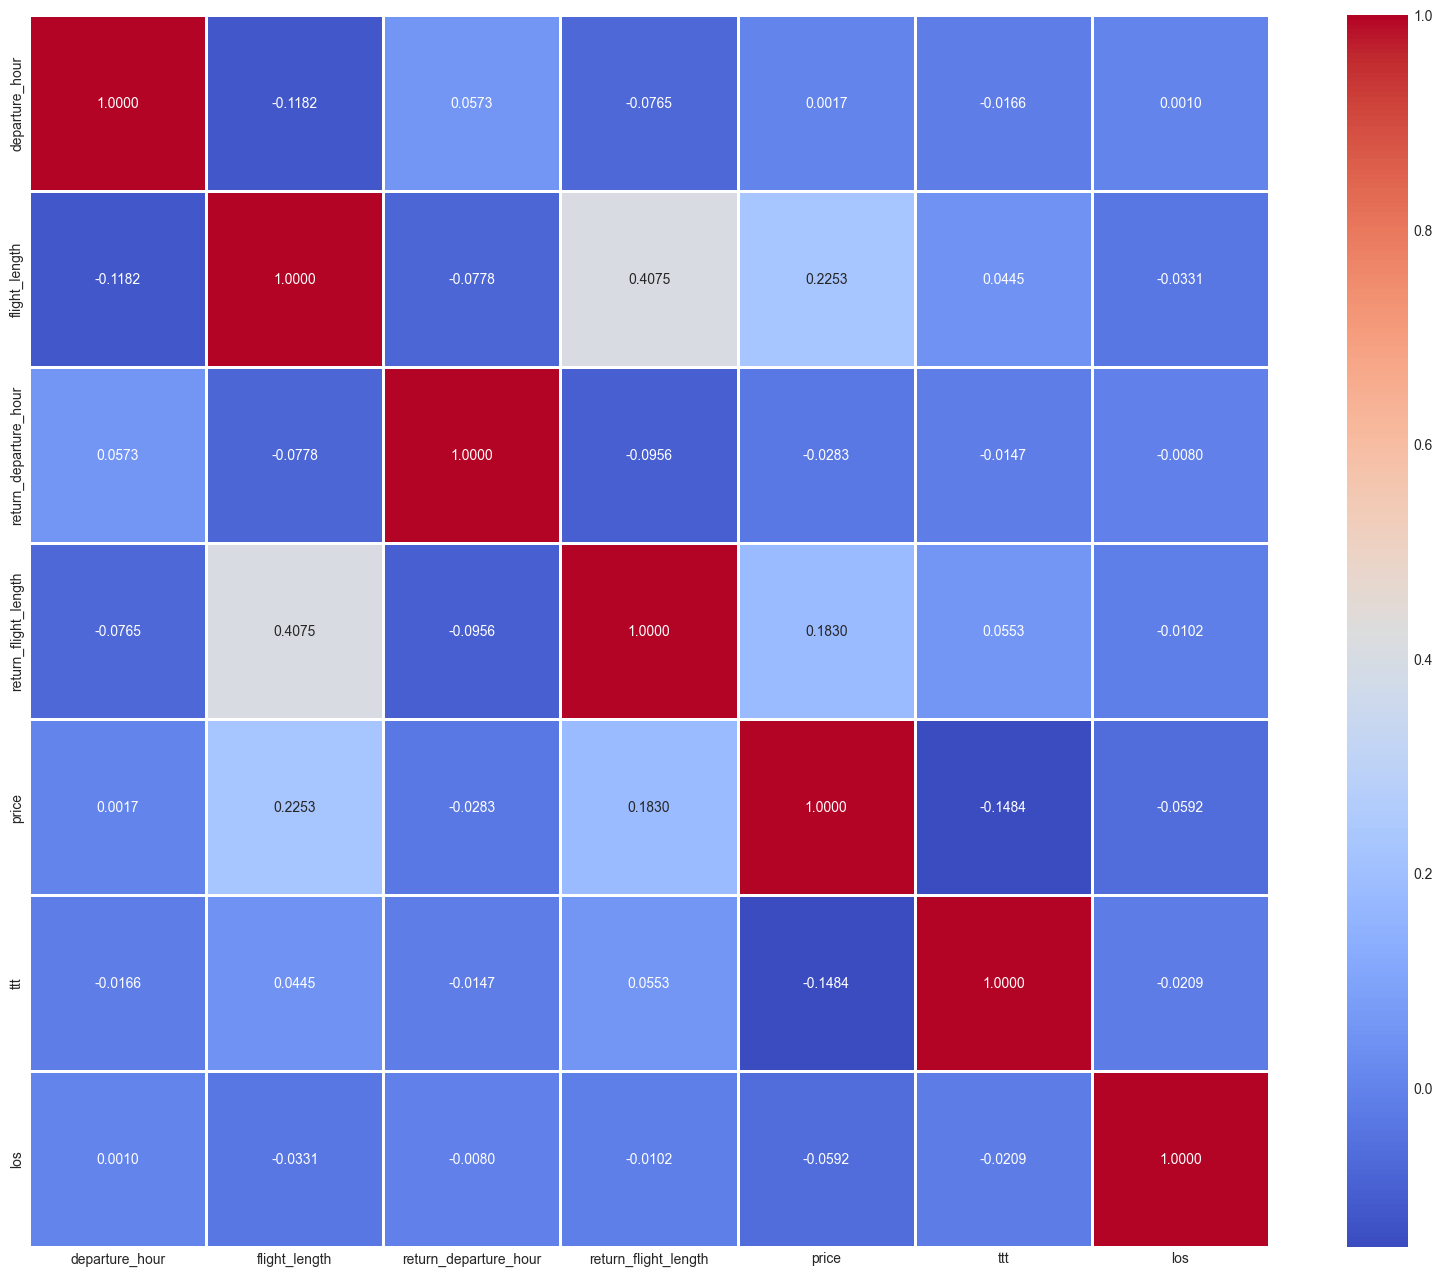

In [ ]:
numeric_cols_refactored = ['departure_hour', 'flight_length', 'return_departure_hour', 'return_flight_length', 'price', 'ttt', 'los']
plt.figure(figsize=(20.0,16))
sns.heatmap(sampled_data[numeric_cols_refactored].corr(),annot=True,cmap='coolwarm',fmt='.4f',linewidths=2)

we can exclude the corr(return_flight_lenght,flight_lenght) because its the same distance (round trip), with domain knowlage we can tell that the corr is not 1 becase the Centrifugal force of earth spining makes one way shorter then the other.
 

### Insights:
- the flight lenghts will have the strongest corr with the price.
- ttt also has influance on the price
- the los influance on the price is very low

## Stage 3: Predictions

#### lets split to train and test data

In [38]:
sample = data.sample(50000, random_state=56476576)
y = sample.price
X =sample.drop(["price"], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

#### This function will get a dict of model name and model obj, will train with the usual traning set, test it and graphiclly represent the scores

In [39]:
def train_models(models, X, y):
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        cv_mse = -cv_scores.mean()
        
        results[name] = {
            'Train MSE': train_mse,
            'Test MSE': test_mse,
            'Train R2': train_r2,
            'Test R2': test_r2,
            'CV MSE': cv_mse,
            'Model': model 
        }
        
        print(f"{name} - Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
        print(f"{name} - Train R2: {train_r2:.2f}, Test R2: {test_r2:.2f}")
        print(f"{name} - CV MSE: {cv_mse:.2f}")

    # Visualize comparison of models
    metrics = ['Test MSE', 'CV MSE', 'Test R2']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 15))

    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in results.keys()]
        axes[i].bar(results.keys(), values)
        axes[i].set_title(f'Model Comparison - {metric}')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()

    # Feature importance analysis for Decision Tree and Random Forest
    # These models allow us to access feature importance directly
    feature_importance_models = ['Decision Tree', 'Random Forest']

    for model_name in feature_importance_models:
        if model_name in results:
            model = results[model_name]['Model']
            
            # Get preprocessed feature names
            feature_names = (
                numerical_features + 
                model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features).tolist()
            )
            
            # Get feature importances
            importances = model.named_steps['regressor'].feature_importances_
            
            # Create DataFrame for visualization
            feature_importance = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            })
            feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)
            
            plt.figure(figsize=(10, 8))
            plt.barh(feature_importance['Feature'], feature_importance['Importance'])
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.title(f'Top 15 Feature Importance - {model_name}')
            plt.tight_layout()


        # Best model selection and final prediction example
        best_model_name = min(results, key=lambda x: results[x]['CV MSE'])
        best_model = results[best_model_name]['Model']
        print(f"\nBest model based on cross-validation: {best_model_name}")
        print(f"CV MSE: {results[best_model_name]['CV MSE']:.2f}")
        print(f"Test R2: {results[best_model_name]['Test R2']:.2f}")

        # Example prediction with best model
        sample_flight = X.iloc[0:1]  # Just using first row as example
        predicted_price = best_model.predict(sample_flight)[0]
        actual_price = y.iloc[0]
        print(f"\nSample prediction with {best_model_name}:")
        print(f"Actual price: ${actual_price:.2f}")
        print(f"Predicted price: ${predicted_price:.2f}")
        print(f"Difference: ${abs(actual_price - predicted_price):.2f}")

##### now lets try numeracl only models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import ElasticNet, Ridge, HuberRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

numerical_features = [
    'departure_hour', 'flight_length', 'landing_hour',
    'return_departure_hour', 'return_flight_length', 'return_landing_hour',
    'ttt', 'los'
]

categorical_features = [
    'departure_airport', 'landing_airport', 'to_dest_company',
    'return_departure_airport', 'return_landing_airport', 'return_company',
    'day_of_week', 'time_category'
]


target = 'price'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


regression_models = {
    
    'Linear Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=random.randint(0, 1000)))
    ]),

    'Ridge Regression': Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=random.randint(0, 1000)))
]),
}



Training Linear Regression...
Linear Regression - Train MSE: 1531.78, Test MSE: 1543.75
Linear Regression - Train R2: 0.52, Test R2: 0.53
Linear Regression - CV MSE: 1547.41

Training Gradient Boosting...
Gradient Boosting - Train MSE: 1286.13, Test MSE: 1285.26
Gradient Boosting - Train R2: 0.60, Test R2: 0.61
Gradient Boosting - CV MSE: 1287.11

Training Ridge Regression...
Ridge Regression - Train MSE: 1532.12, Test MSE: 1542.87
Ridge Regression - Train R2: 0.52, Test R2: 0.53
Ridge Regression - CV MSE: 1546.93

Best model based on cross-validation: Gradient Boosting
CV MSE: 1287.11
Test R2: 0.61

Sample prediction with Gradient Boosting:
Actual price: $217.00
Predicted price: $188.05
Difference: $28.95

Best model based on cross-validation: Gradient Boosting
CV MSE: 1287.11
Test R2: 0.61

Sample prediction with Gradient Boosting:
Actual price: $217.00
Predicted price: $188.05
Difference: $28.95


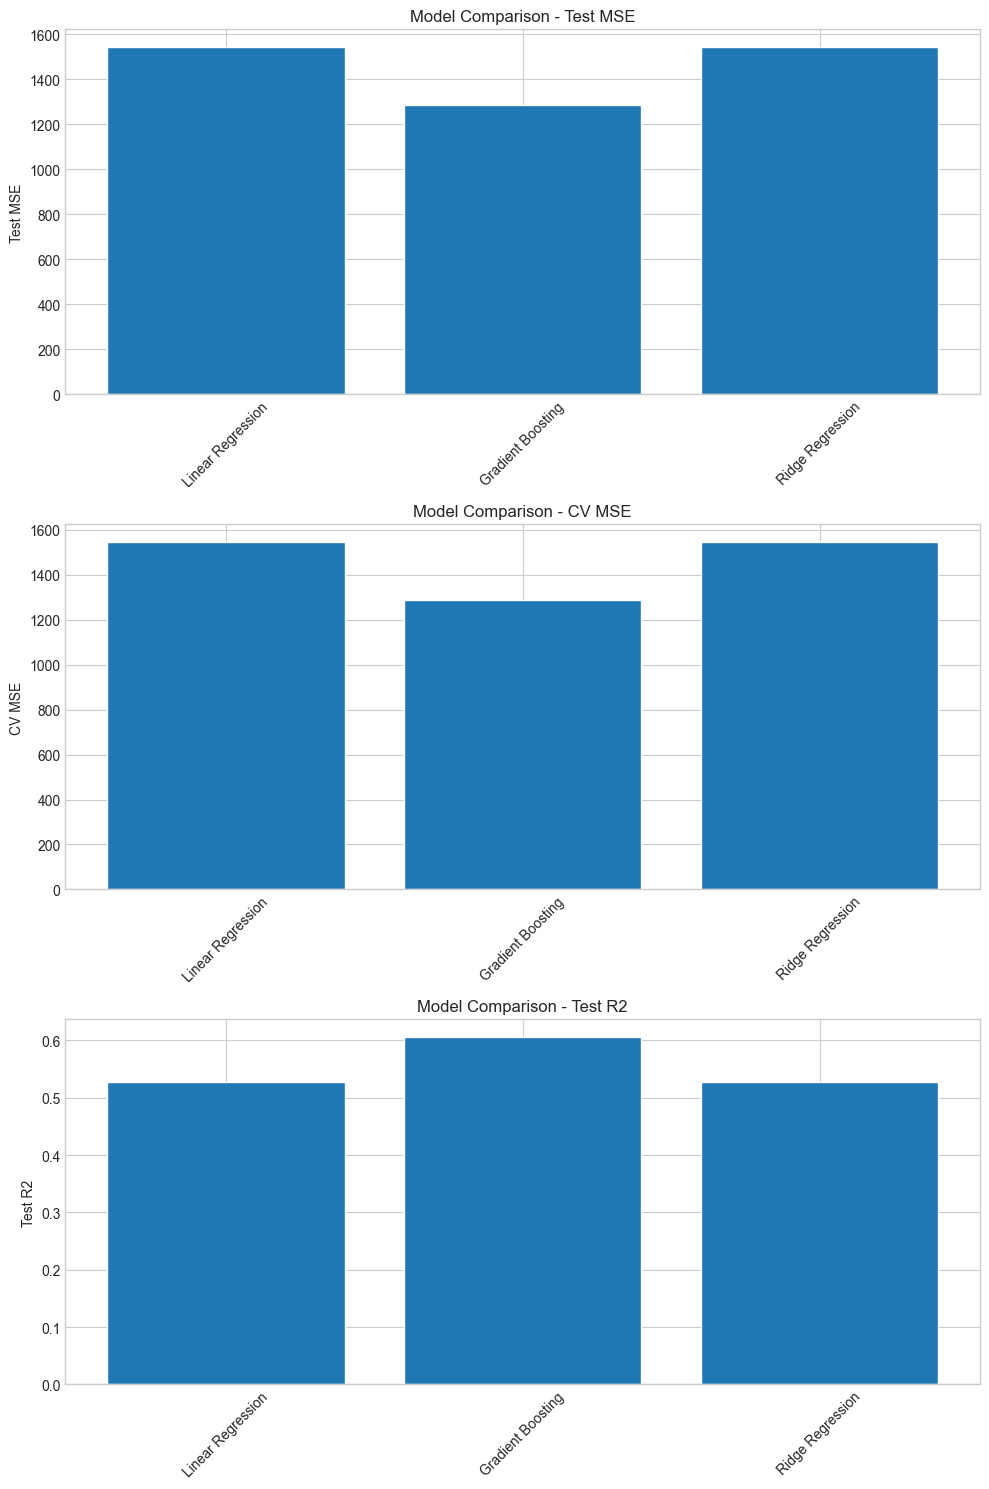

In [46]:
train_models(regression_models, X, y)

### Now lets try to train more complex models (with hyper parameters tuning)

In [48]:
def train_models(model_params, X, y, X_train, X_test, y_train, y_test, categorical_features=None, numerical_features=None):
    """
    Train models with hyperparameter tuning using GridSearchCV.
    
    Parameters:
    model_params (dict): Dictionary with model names as keys and tuples of (model, param_grid) as values
    X, y: Full dataset for cross-validation
    X_train, X_test, y_train, y_test: Train/test split datasets
    categorical_features, numerical_features: Lists of feature names for feature importance plotting
    
    Returns:
    dict: Results containing model performance metrics and tuned models
    """
    from sklearn.model_selection import GridSearchCV, cross_val_score
    from sklearn.metrics import mean_squared_error, r2_score
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import time
    
    results = {}
    
    for name, (model, param_grid) in model_params.items():
        start_time = time.time()
        print(f"\nTraining {name}...")
        
        # Grid Search with cross-validation
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1  # Use all available cores
        )
        
        # Fit grid search
        grid_search.fit(X_train, y_train)
        
        # Get best model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
        # Make predictions
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Cross-validation on full dataset with best model
        cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
        cv_mse = -cv_scores.mean()
        
        results[name] = {
            'Train MSE': train_mse,
            'Test MSE': test_mse,
            'Train R2': train_r2,
            'Test R2': test_r2,
            'CV MSE': cv_mse,
            'Best Parameters': best_params,
            'Model': best_model
        }
        
        print(f"{name} - Best Parameters: {best_params}")
        print(f"{name} - Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
        print(f"{name} - Train R2: {train_r2:.2f}, Test R2: {test_r2:.2f}")
        print(f"{name} - CV MSE: {cv_mse:.2f}")

    # Visualize comparison of models
    metrics = ['Test MSE', 'CV MSE', 'Test R2']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 15))

    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in results.keys()]
        axes[i].bar(results.keys(), values)
        axes[i].set_title(f'Model Comparison - {metric}')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Feature importance analysis for models that support it
    if numerical_features is not None and categorical_features is not None:
        feature_importance_models = ['Decision Tree', 'Random Forest']
        
        for model_name in feature_importance_models:
            if model_name in results:
                try:
                    model = results[model_name]['Model']
                    
                    # Get feature importances
                    if hasattr(model.named_steps['regressor'], 'feature_importances_'):
                        importances = model.named_steps['regressor'].feature_importances_
                        
                        # Get feature names
                        feature_names = numerical_features + [f"{col}_{cat}" for col in categorical_features 
                                                           for cat in model.named_steps['preprocessor'].transformers_[1][1].categories_[
                                                               categorical_features.index(col)]]
                        
                        # Check if lengths match
                        if len(importances) == len(feature_names):
                            # Create DataFrame for visualization
                            feature_importance = pd.DataFrame({
                                'Feature': feature_names,
                                'Importance': importances
                            })
                            feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)
                            
                            plt.figure(figsize=(10, 8))
                            plt.barh(feature_importance['Feature'], feature_importance['Importance'])
                            plt.xlabel('Importance')
                            plt.ylabel('Feature')
                            plt.title(f'Top 15 Feature Importance - {model_name}')
                            plt.tight_layout()
                            plt.show()
                        else:
                            print(f"Feature names count ({len(feature_names)}) doesn't match importance count ({len(importances)})")
                except Exception as e:
                    print(f"Error extracting feature importance for {model_name}: {str(e)}")

    # Best model selection and final prediction example
    best_model_name = min(results, key=lambda x: results[x]['CV MSE'])
    best_model = results[best_model_name]['Model']
    print(f"\nBest model based on cross-validation: {best_model_name}")
    print(f"CV MSE: {results[best_model_name]['CV MSE']:.2f}")
    print(f"Test R2: {results[best_model_name]['Test R2']:.2f}")
    print(f"Best Parameters: {results[best_model_name]['Best Parameters']}")

    # Example prediction with best model
    sample_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
    
    print(f"\nSample predictions with {best_model_name}:")
    print(f"{'Actual':>10} {'Predicted':>10} {'Difference':>10} {'Error %':>10}")
    print("-" * 45)
    
    for idx in sample_indices:
        sample = X_test.iloc[idx:idx+1]
        actual = y_test.iloc[idx]
        predicted = best_model.predict(sample)[0]
        diff = abs(actual - predicted)
        error_pct = (diff / actual) * 100 if actual != 0 else float('inf')
        
        print(f"${actual:>9.2f} ${predicted:>9.2f} ${diff:>9.2f} {error_pct:>9.2f}%")
    
    return results

In [51]:
from sklearn.model_selection import GridSearchCV

# This new Processor  ensures all categorical features are converted to dense arrays andSolves compatibility issues with models like Gaussian Process and Naive Bayes that require dense input
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Hyperparameter tuning for models
hyper_tuning_models = {
'Decision Tree': (
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=random.randint(0,1000)))
    ]),
    {
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
),

'Gaussian Process': (
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GaussianProcessRegressor(
            kernel=RBF() + WhiteKernel(),
            random_state=random.randint(0,1000),
            n_restarts_optimizer=2
        ))
    ]),
    {
        'regressor__alpha': [1e-10, 1e-8, 1e-6],
        'regressor__kernel': [RBF() + WhiteKernel(), 
                            1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)]
    }
),

'Random Forest': (
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=random.randint(0,1000)))
    ]),
    {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
),

'KNN Regressor': (
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor())
    ]),
    {
        'regressor__n_neighbors': [3, 5, 7, 9],
        'regressor__weights': ['uniform', 'distance'],
        'regressor__p': [1, 2]
    }
),

'ElasticNet': (
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', ElasticNet(random_state=random.randint(0,1000)))
    ]),
    {
        'regressor__alpha': [0.1, 0.5, 1.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9],
        'regressor__max_iter': [1000, 2000]
    }
),

'SVR': (
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ]),
    {
        'regressor__kernel': ['linear', 'rbf', 'poly'],
        'regressor__C': [0.1, 1.0, 10.0],
        'regressor__epsilon': [0.1, 0.2, 0.5]
    }
),

'Naive Bayes': (
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GaussianNB())
    ]),
    {
        'regressor__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    }
)
}

In [ ]:
train_models(hyper_tuning_models, X, y, X_train, X_test, y_train, y_test, categorical_features, numerical_features)


Training Decision Tree...


Decision Tree - Best Parameters: {'regressor__max_depth': 30, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10}
Decision Tree - Train MSE: 329.91, Test MSE: 897.63
Decision Tree - Train R2: 0.90, Test R2: 0.73
Decision Tree - CV MSE: 857.94

Training Gaussian Process...
